In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '/Users/tareen/Desktop/Research_Projects/2022_mavenn2_github/mavenn')

import mavenn
import logomaker
import seaborn as sns
import re

%matplotlib inline

In [2]:
def get_titeseq_replicate_df(replicate_number='1'):

    data_df_full = pd.read_csv(f'data/replicate_{replicate_number}.csv',index_col=[0])
    y_cols = list(data_df_full.columns[14:58])
    cols = y_cols.copy()
    # Currently concatenating CDR1-H and CDR3-H sequencnes. Not sure if correct.
    data_df_full['x'] = (data_df_full['CDR1H_AA']+data_df_full['CDR3H_AA']).values
    cols.insert(0,'x')
    data_df = data_df_full[cols].copy()
    
    return data_df
    

In [3]:
replicate_1_df = get_titeseq_replicate_df('1')
replicate_2_df = get_titeseq_replicate_df('2')
replicate_3_df = get_titeseq_replicate_df('3')

data_df = replicate_1_df.append(replicate_2_df, ignore_index=True).append(replicate_3_df, ignore_index=True).reset_index(drop=True).copy()

In [4]:
data_df_full_rep_1 = pd.read_csv(f'data/replicate_1.csv',index_col=[0])
y_cols = list(data_df_full_rep_1.columns[14:58])
X = data_df['x']
y = data_df[y_cols]

In [5]:
# set positional argumnets for gpmap function
L = len(data_df['x'][0])
alphabet=['A', 'C', 'D', 'E', 'F',
          'G', 'H', 'I', 'K', 'L',
          'M', 'N', 'P', 'Q', 'R',
          'S', 'T', 'V', 'W', 'Y',]


Y = len(y_cols)
print(f'L={L}, Y={Y}')

L=20, Y=44


In [6]:
gpmap = mavenn.gpmap.AdditiveGPMapLayer(L, alphabet)

# # instantiate gpmap object
# gpmap = mavenn.gpmap.Multi_AdditiveGPMapLayer(L=L, 
#                                               alphabet=alphabet,
#                                               number_latent_nodes=2)



2022-08-03 20:38:10.050989: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
from sklearn.model_selection import train_test_split

# split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [8]:
# read in parameters

# number of reads in each bin summed
N_y = np.sum(y,axis=0)

In [9]:
print(N_y)

fluorescein0bin0          15885950
fluorescein0bin1            845949
fluorescein0bin2          14646947
fluorescein0bin3            480168
fluorescein10^-5.5bin0     4938811
fluorescein10^-5.5bin1     3558812
fluorescein10^-5.5bin2     7335952
fluorescein10^-5.5bin3     7306329
fluorescein10^-5bin0      12323072
fluorescein10^-5bin1       1386792
fluorescein10^-5bin2      14067051
fluorescein10^-5bin3      14797633
fluorescein10^-6.5bin0     7778006
fluorescein10^-6.5bin1     1084990
fluorescein10^-6.5bin2     6335215
fluorescein10^-6.5bin3    14460000
fluorescein10^-6bin0       1870048
fluorescein10^-6bin1       6027256
fluorescein10^-6bin2       2933272
fluorescein10^-6bin3      10097157
fluorescein10^-7.5bin0     3535644
fluorescein10^-7.5bin1     1078611
fluorescein10^-7.5bin2     3070755
fluorescein10^-7.5bin3     3000078
fluorescein10^-7bin0       3645702
fluorescein10^-7bin1        565856
fluorescein10^-7bin2       8837515
fluorescein10^-7bin3       2756860
fluorescein10^-8.5bi

#### I approximated these values from Fig 2B

In [10]:
bounds = np.array([[0,180],[180,1400],[1400,10500],[10500,250000]])
bounds_df = pd.DataFrame(bounds,columns=['lower_bound','upper_bound'])
f_y_lower_bounds = bounds_df['lower_bound'].values
f_y_upper_bounds = bounds_df['upper_bound'].values
bounds_df

,lower_bound,upper_bound
0,0,180
1,180,1400
2,1400,10500
3,10500,250000


### I don't know how to obtain these values
Using arbitrary values for now just to be able to debug Titeseq MP.
Get these from figure 2B

In [11]:
mu_neg = 50
mu_pos = 700000
sigma_neg = 100
sigma_pos = 50000

In [12]:
mp_list = [mavenn.measurement_process_layers.DiscreteMonotonicMP(info_for_layers_dict={'H_y_norm':0},
                                                                      Y=4,
                                                                      K=10,
                                                                      eta=1e-5,)
           for mp in range(len(y_cols)//4)
          ]

In [13]:
# there are 16 measurement processes in this 
len(mp_list)

11

In [14]:
model = mavenn.Model2(gpmap=gpmap,
                      mp_list=mp_list)

In [15]:
model.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Sequence_labels_input (InputLa  [(None, 444)]       0           []                               
 yer)                                                                                             
                                                                                                  
 Sequence_only (Lambda)         (None, 400)          0           ['Sequence_labels_input[0][0]']  
                                                                                                  
 additive_gp_map_layer (Additiv  (None, 1)           401         ['Sequence_only[0][0]']          
 eGPMapLayer)                                                                                     
                                                                                              

In [16]:
# Set training data
model.set_data(x=x_train,
               
               y_list=[
                       y_train[y_cols[0:4]].values,
                       y_train[y_cols[4:8]].values,
                       y_train[y_cols[8:12]].values,
                       y_train[y_cols[12:16]].values,
                       y_train[y_cols[16:20]].values,
                       y_train[y_cols[20:24]].values,
                       y_train[y_cols[24:28]].values,
                       y_train[y_cols[28:32]].values,
                       y_train[y_cols[32:36]].values,
                       y_train[y_cols[36:40]].values,
                       y_train[y_cols[40:44]].values,                                                        
                      ],

               shuffle=False)

N = 10,487 observations set as training data.
Using 20.0% for validation.
Time to set data: 0.455 sec.


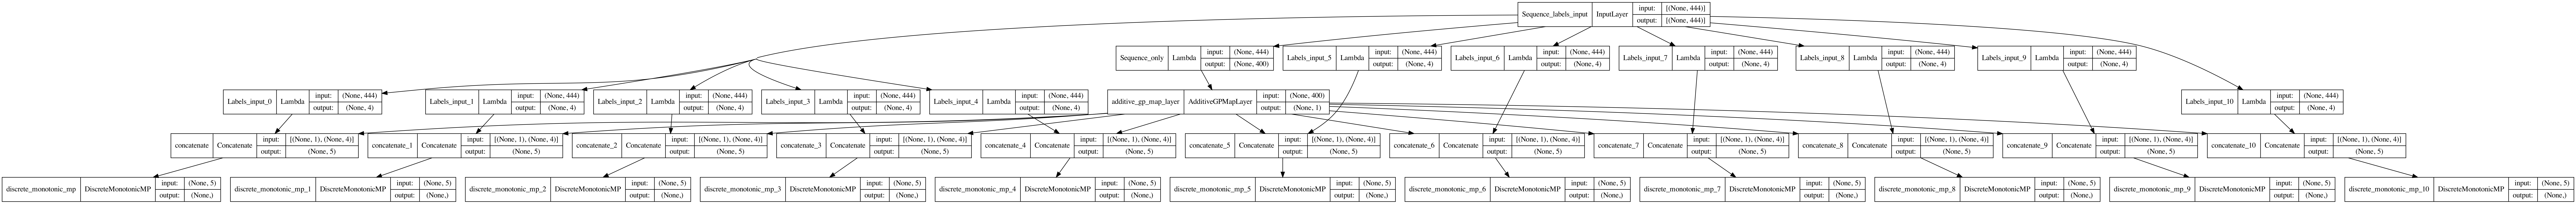

In [17]:
from tensorflow.keras.utils import plot_model
plot_model(model.model,show_shapes=True,show_dtype=False,dpi=300,to_file='pngs/DiscreteMonotonic_MP/titeseq16_dar.png')

In [18]:

# Fit model to data
model.fit(learning_rate=.0001,
          epochs=500,
          batch_size=200,
          try_tqdm = False,
          early_stopping=True,
          early_stopping_patience=10,
          linear_initialization=False)

Epoch 1/500
42/42 [==============================] - 10s 48ms/step - loss: 9058485.0000 - discrete_monotonic_mp_loss: 831115.6250 - discrete_monotonic_mp_1_loss: 726422.4375 - discrete_monotonic_mp_2_loss: 1327206.3750 - discrete_monotonic_mp_3_loss: 948321.1875 - discrete_monotonic_mp_4_loss: 712539.0625 - discrete_monotonic_mp_5_loss: 299088.5000 - discrete_monotonic_mp_6_loss: 442658.7812 - discrete_monotonic_mp_7_loss: 1134674.0000 - discrete_monotonic_mp_8_loss: 667704.8125 - discrete_monotonic_mp_9_loss: 997123.1875 - discrete_monotonic_mp_10_loss: 971631.3750 - I_var: -0.2559 - val_loss: 5302232.5000 - val_discrete_monotonic_mp_loss: 537186.2500 - val_discrete_monotonic_mp_1_loss: 443586.9062 - val_discrete_monotonic_mp_2_loss: 757637.5000 - val_discrete_monotonic_mp_3_loss: 506340.7812 - val_discrete_monotonic_mp_4_loss: 402769.6250 - val_discrete_monotonic_mp_5_loss: 253146.3750 - val_discrete_monotonic_mp_6_loss: 317661.3438 - val_discrete_monotonic_mp_7_loss: 604666.3125 - v

42/42 [==============================] - 0s 7ms/step - loss: 8420595.0000 - discrete_monotonic_mp_loss: 845491.6875 - discrete_monotonic_mp_1_loss: 653984.1875 - discrete_monotonic_mp_2_loss: 1218140.2500 - discrete_monotonic_mp_3_loss: 858255.4375 - discrete_monotonic_mp_4_loss: 619743.6875 - discrete_monotonic_mp_5_loss: 287438.2812 - discrete_monotonic_mp_6_loss: 422105.3750 - discrete_monotonic_mp_7_loss: 1078481.0000 - discrete_monotonic_mp_8_loss: 622429.4375 - discrete_monotonic_mp_9_loss: 928943.3125 - discrete_monotonic_mp_10_loss: 885580.3125 - I_var: -0.1824 - val_loss: 5138132.0000 - val_discrete_monotonic_mp_loss: 544528.1875 - val_discrete_monotonic_mp_1_loss: 417604.5625 - val_discrete_monotonic_mp_2_loss: 721452.4375 - val_discrete_monotonic_mp_3_loss: 485142.7500 - val_discrete_monotonic_mp_4_loss: 373842.6875 - val_discrete_monotonic_mp_5_loss: 248423.2500 - val_discrete_monotonic_mp_6_loss: 312741.1250 - val_discrete_monotonic_mp_7_loss: 601926.1875 - val_discrete_mo

42/42 [==============================] - 0s 7ms/step - loss: 8061980.0000 - discrete_monotonic_mp_loss: 861323.1250 - discrete_monotonic_mp_1_loss: 616300.0625 - discrete_monotonic_mp_2_loss: 1158710.2500 - discrete_monotonic_mp_3_loss: 805788.0000 - discrete_monotonic_mp_4_loss: 562866.2500 - discrete_monotonic_mp_5_loss: 281734.0938 - discrete_monotonic_mp_6_loss: 410001.2188 - discrete_monotonic_mp_7_loss: 1047657.1875 - discrete_monotonic_mp_8_loss: 595571.8750 - discrete_monotonic_mp_9_loss: 885212.1250 - discrete_monotonic_mp_10_loss: 836815.8125 - I_var: -0.1358 - val_loss: 5061521.5000 - val_discrete_monotonic_mp_loss: 551673.6875 - val_discrete_monotonic_mp_1_loss: 405301.5625 - val_discrete_monotonic_mp_2_loss: 703256.7500 - val_discrete_monotonic_mp_3_loss: 474579.0312 - val_discrete_monotonic_mp_4_loss: 358003.8125 - val_discrete_monotonic_mp_5_loss: 246258.5781 - val_discrete_monotonic_mp_6_loss: 309340.1250 - val_discrete_monotonic_mp_7_loss: 602632.6250 - val_discrete_mo

42/42 [==============================] - 0s 7ms/step - loss: 7854965.0000 - discrete_monotonic_mp_loss: 868917.0000 - discrete_monotonic_mp_1_loss: 597816.9375 - discrete_monotonic_mp_2_loss: 1126454.1250 - discrete_monotonic_mp_3_loss: 776273.1875 - discrete_monotonic_mp_4_loss: 529305.0000 - discrete_monotonic_mp_5_loss: 278620.1875 - discrete_monotonic_mp_6_loss: 401682.1250 - discrete_monotonic_mp_7_loss: 1028269.9375 - discrete_monotonic_mp_8_loss: 578718.2500 - discrete_monotonic_mp_9_loss: 859917.3750 - discrete_monotonic_mp_10_loss: 808991.5625 - I_var: -0.1300 - val_loss: 5019955.5000 - val_discrete_monotonic_mp_loss: 553363.6250 - val_discrete_monotonic_mp_1_loss: 399899.3438 - val_discrete_monotonic_mp_2_loss: 694278.9375 - val_discrete_monotonic_mp_3_loss: 468956.3125 - val_discrete_monotonic_mp_4_loss: 349986.4375 - val_discrete_monotonic_mp_5_loss: 244921.7969 - val_discrete_monotonic_mp_6_loss: 305067.4375 - val_discrete_monotonic_mp_7_loss: 603244.1875 - val_discrete_mo

42/42 [==============================] - 0s 7ms/step - loss: 7707743.5000 - discrete_monotonic_mp_loss: 868460.6875 - discrete_monotonic_mp_1_loss: 587573.4375 - discrete_monotonic_mp_2_loss: 1107222.2500 - discrete_monotonic_mp_3_loss: 754349.4375 - discrete_monotonic_mp_4_loss: 507079.8750 - discrete_monotonic_mp_5_loss: 276785.6562 - discrete_monotonic_mp_6_loss: 393777.8438 - discrete_monotonic_mp_7_loss: 1014972.9375 - discrete_monotonic_mp_8_loss: 567805.8750 - discrete_monotonic_mp_9_loss: 838232.6875 - discrete_monotonic_mp_10_loss: 791482.0000 - I_var: -0.1294 - val_loss: 4989371.0000 - val_discrete_monotonic_mp_loss: 550436.4375 - val_discrete_monotonic_mp_1_loss: 397325.7500 - val_discrete_monotonic_mp_2_loss: 688981.9375 - val_discrete_monotonic_mp_3_loss: 465156.2188 - val_discrete_monotonic_mp_4_loss: 345624.8438 - val_discrete_monotonic_mp_5_loss: 243679.5625 - val_discrete_monotonic_mp_6_loss: 299203.6875 - val_discrete_monotonic_mp_7_loss: 603285.8750 - val_discrete_mo

42/42 [==============================] - 0s 7ms/step - loss: 7589601.0000 - discrete_monotonic_mp_loss: 861065.3125 - discrete_monotonic_mp_1_loss: 581627.9375 - discrete_monotonic_mp_2_loss: 1093655.3750 - discrete_monotonic_mp_3_loss: 737224.1875 - discrete_monotonic_mp_4_loss: 491295.1250 - discrete_monotonic_mp_5_loss: 275119.4688 - discrete_monotonic_mp_6_loss: 386226.9688 - discrete_monotonic_mp_7_loss: 1000923.1250 - discrete_monotonic_mp_8_loss: 559672.5000 - discrete_monotonic_mp_9_loss: 823166.4375 - discrete_monotonic_mp_10_loss: 779623.7500 - I_var: -0.1374 - val_loss: 4963178.0000 - val_discrete_monotonic_mp_loss: 544875.2500 - val_discrete_monotonic_mp_1_loss: 396009.0938 - val_discrete_monotonic_mp_2_loss: 685252.9375 - val_discrete_monotonic_mp_3_loss: 462305.8750 - val_discrete_monotonic_mp_4_loss: 343348.2188 - val_discrete_monotonic_mp_5_loss: 242381.3125 - val_discrete_monotonic_mp_6_loss: 293147.9375 - val_discrete_monotonic_mp_7_loss: 602299.1875 - val_discrete_mo

42/42 [==============================] - 0s 10ms/step - loss: 7493180.5000 - discrete_monotonic_mp_loss: 852737.9375 - discrete_monotonic_mp_1_loss: 577952.1250 - discrete_monotonic_mp_2_loss: 1083778.6250 - discrete_monotonic_mp_3_loss: 722619.7500 - discrete_monotonic_mp_4_loss: 480068.2188 - discrete_monotonic_mp_5_loss: 273533.3750 - discrete_monotonic_mp_6_loss: 379219.5312 - discrete_monotonic_mp_7_loss: 987377.2500 - discrete_monotonic_mp_8_loss: 553841.4375 - discrete_monotonic_mp_9_loss: 810877.7500 - discrete_monotonic_mp_10_loss: 771174.6875 - I_var: -0.1377 - val_loss: 4938110.5000 - val_discrete_monotonic_mp_loss: 539845.0625 - val_discrete_monotonic_mp_1_loss: 394930.2500 - val_discrete_monotonic_mp_2_loss: 681832.2500 - val_discrete_monotonic_mp_3_loss: 459905.7500 - val_discrete_monotonic_mp_4_loss: 341872.0625 - val_discrete_monotonic_mp_5_loss: 240601.5156 - val_discrete_monotonic_mp_6_loss: 287905.9375 - val_discrete_monotonic_mp_7_loss: 600198.8125 - val_discrete_mo

42/42 [==============================] - 0s 9ms/step - loss: 7414274.0000 - discrete_monotonic_mp_loss: 845592.4375 - discrete_monotonic_mp_1_loss: 575156.2500 - discrete_monotonic_mp_2_loss: 1075606.5000 - discrete_monotonic_mp_3_loss: 709594.5000 - discrete_monotonic_mp_4_loss: 471281.3438 - discrete_monotonic_mp_5_loss: 272104.0000 - discrete_monotonic_mp_6_loss: 372621.0938 - discrete_monotonic_mp_7_loss: 975128.0000 - discrete_monotonic_mp_8_loss: 548868.6875 - discrete_monotonic_mp_9_loss: 803703.6250 - discrete_monotonic_mp_10_loss: 764616.3750 - I_var: -0.1325 - val_loss: 4917740.0000 - val_discrete_monotonic_mp_loss: 535481.9375 - val_discrete_monotonic_mp_1_loss: 394136.8438 - val_discrete_monotonic_mp_2_loss: 678930.3125 - val_discrete_monotonic_mp_3_loss: 457939.5938 - val_discrete_monotonic_mp_4_loss: 341053.5312 - val_discrete_monotonic_mp_5_loss: 239175.2188 - val_discrete_monotonic_mp_6_loss: 283403.9688 - val_discrete_monotonic_mp_7_loss: 598104.3125 - val_discrete_mon

42/42 [==============================] - 0s 10ms/step - loss: 7347806.0000 - discrete_monotonic_mp_loss: 838838.7500 - discrete_monotonic_mp_1_loss: 573073.1250 - discrete_monotonic_mp_2_loss: 1069102.0000 - discrete_monotonic_mp_3_loss: 699095.1875 - discrete_monotonic_mp_4_loss: 465001.5625 - discrete_monotonic_mp_5_loss: 270804.5625 - discrete_monotonic_mp_6_loss: 366989.9375 - discrete_monotonic_mp_7_loss: 963850.5625 - discrete_monotonic_mp_8_loss: 544935.0625 - discrete_monotonic_mp_9_loss: 796769.5000 - discrete_monotonic_mp_10_loss: 759343.8125 - I_var: -0.1399 - val_loss: 4895840.0000 - val_discrete_monotonic_mp_loss: 531532.1250 - val_discrete_monotonic_mp_1_loss: 393143.9062 - val_discrete_monotonic_mp_2_loss: 675915.8750 - val_discrete_monotonic_mp_3_loss: 455900.4375 - val_discrete_monotonic_mp_4_loss: 340212.6250 - val_discrete_monotonic_mp_5_loss: 237748.0312 - val_discrete_monotonic_mp_6_loss: 279815.9375 - val_discrete_monotonic_mp_7_loss: 595301.6250 - val_discrete_mo

42/42 [==============================] - 0s 10ms/step - loss: 7288717.5000 - discrete_monotonic_mp_loss: 832920.6875 - discrete_monotonic_mp_1_loss: 571012.5625 - discrete_monotonic_mp_2_loss: 1063255.3750 - discrete_monotonic_mp_3_loss: 689828.1250 - discrete_monotonic_mp_4_loss: 460025.1250 - discrete_monotonic_mp_5_loss: 269409.3125 - discrete_monotonic_mp_6_loss: 362391.8438 - discrete_monotonic_mp_7_loss: 953265.2500 - discrete_monotonic_mp_8_loss: 541242.9375 - discrete_monotonic_mp_9_loss: 790958.5000 - discrete_monotonic_mp_10_loss: 754406.7500 - I_var: -0.1233 - val_loss: 4870140.0000 - val_discrete_monotonic_mp_loss: 528328.8125 - val_discrete_monotonic_mp_1_loss: 391779.5312 - val_discrete_monotonic_mp_2_loss: 672498.5000 - val_discrete_monotonic_mp_3_loss: 453413.8438 - val_discrete_monotonic_mp_4_loss: 338957.5312 - val_discrete_monotonic_mp_5_loss: 236335.9375 - val_discrete_monotonic_mp_6_loss: 277369.0312 - val_discrete_monotonic_mp_7_loss: 591473.6250 - val_discrete_mo

42/42 [==============================] - 0s 9ms/step - loss: 7233729.5000 - discrete_monotonic_mp_loss: 828283.8750 - discrete_monotonic_mp_1_loss: 569055.9375 - discrete_monotonic_mp_2_loss: 1057825.8750 - discrete_monotonic_mp_3_loss: 681615.6250 - discrete_monotonic_mp_4_loss: 455737.0000 - discrete_monotonic_mp_5_loss: 268236.9375 - discrete_monotonic_mp_6_loss: 358433.0938 - discrete_monotonic_mp_7_loss: 943430.8125 - discrete_monotonic_mp_8_loss: 537641.2500 - discrete_monotonic_mp_9_loss: 784088.2500 - discrete_monotonic_mp_10_loss: 749381.1250 - I_var: -0.1138 - val_loss: 4846996.5000 - val_discrete_monotonic_mp_loss: 525696.1250 - val_discrete_monotonic_mp_1_loss: 390616.1562 - val_discrete_monotonic_mp_2_loss: 669339.7500 - val_discrete_monotonic_mp_3_loss: 451060.5625 - val_discrete_monotonic_mp_4_loss: 337772.0000 - val_discrete_monotonic_mp_5_loss: 235390.2500 - val_discrete_monotonic_mp_6_loss: 275120.4375 - val_discrete_monotonic_mp_7_loss: 587802.0625 - val_discrete_mon

42/42 [==============================] - 0s 9ms/step - loss: 7183394.5000 - discrete_monotonic_mp_loss: 824191.0625 - discrete_monotonic_mp_1_loss: 567192.5625 - discrete_monotonic_mp_2_loss: 1052547.5000 - discrete_monotonic_mp_3_loss: 673726.3125 - discrete_monotonic_mp_4_loss: 451603.7812 - discrete_monotonic_mp_5_loss: 267048.6875 - discrete_monotonic_mp_6_loss: 354781.7500 - discrete_monotonic_mp_7_loss: 934176.0000 - discrete_monotonic_mp_8_loss: 534218.5000 - discrete_monotonic_mp_9_loss: 779171.5625 - discrete_monotonic_mp_10_loss: 744736.3125 - I_var: -0.1076 - val_loss: 4823047.0000 - val_discrete_monotonic_mp_loss: 523288.9688 - val_discrete_monotonic_mp_1_loss: 389412.5312 - val_discrete_monotonic_mp_2_loss: 666168.7500 - val_discrete_monotonic_mp_3_loss: 448492.2500 - val_discrete_monotonic_mp_4_loss: 336383.2188 - val_discrete_monotonic_mp_5_loss: 234532.7656 - val_discrete_monotonic_mp_6_loss: 273563.5938 - val_discrete_monotonic_mp_7_loss: 583712.2500 - val_discrete_mon

42/42 [==============================] - 0s 11ms/step - loss: 7140578.5000 - discrete_monotonic_mp_loss: 820477.2500 - discrete_monotonic_mp_1_loss: 565556.1875 - discrete_monotonic_mp_2_loss: 1048106.6875 - discrete_monotonic_mp_3_loss: 666663.5000 - discrete_monotonic_mp_4_loss: 448283.8438 - discrete_monotonic_mp_5_loss: 265990.6250 - discrete_monotonic_mp_6_loss: 351904.0312 - discrete_monotonic_mp_7_loss: 926079.0000 - discrete_monotonic_mp_8_loss: 531247.5625 - discrete_monotonic_mp_9_loss: 775561.2500 - discrete_monotonic_mp_10_loss: 740708.4375 - I_var: -0.0920 - val_loss: 4798959.5000 - val_discrete_monotonic_mp_loss: 520998.9375 - val_discrete_monotonic_mp_1_loss: 388260.6250 - val_discrete_monotonic_mp_2_loss: 663079.3125 - val_discrete_monotonic_mp_3_loss: 445829.5312 - val_discrete_monotonic_mp_4_loss: 334866.3438 - val_discrete_monotonic_mp_5_loss: 233784.6719 - val_discrete_monotonic_mp_6_loss: 272246.8750 - val_discrete_monotonic_mp_7_loss: 579352.4375 - val_discrete_mo

42/42 [==============================] - 0s 11ms/step - loss: 7093909.5000 - discrete_monotonic_mp_loss: 816525.8125 - discrete_monotonic_mp_1_loss: 563729.2500 - discrete_monotonic_mp_2_loss: 1043255.6250 - discrete_monotonic_mp_3_loss: 659747.1875 - discrete_monotonic_mp_4_loss: 444822.9062 - discrete_monotonic_mp_5_loss: 264828.9375 - discrete_monotonic_mp_6_loss: 349208.5625 - discrete_monotonic_mp_7_loss: 917777.8750 - discrete_monotonic_mp_8_loss: 527693.5625 - discrete_monotonic_mp_9_loss: 770454.5625 - discrete_monotonic_mp_10_loss: 735864.7500 - I_var: -0.0798 - val_loss: 4773611.5000 - val_discrete_monotonic_mp_loss: 518773.5625 - val_discrete_monotonic_mp_1_loss: 387118.1875 - val_discrete_monotonic_mp_2_loss: 660046.6875 - val_discrete_monotonic_mp_3_loss: 442955.6562 - val_discrete_monotonic_mp_4_loss: 333205.4688 - val_discrete_monotonic_mp_5_loss: 233098.4375 - val_discrete_monotonic_mp_6_loss: 270929.1250 - val_discrete_monotonic_mp_7_loss: 574510.8750 - val_discrete_mo

42/42 [==============================] - 1s 18ms/step - loss: 7053631.5000 - discrete_monotonic_mp_loss: 811741.8750 - discrete_monotonic_mp_1_loss: 562236.2500 - discrete_monotonic_mp_2_loss: 1039424.5625 - discrete_monotonic_mp_3_loss: 654031.0625 - discrete_monotonic_mp_4_loss: 442267.0938 - discrete_monotonic_mp_5_loss: 263823.7188 - discrete_monotonic_mp_6_loss: 346965.5312 - discrete_monotonic_mp_7_loss: 910906.1875 - discrete_monotonic_mp_8_loss: 524684.4375 - discrete_monotonic_mp_9_loss: 765608.6875 - discrete_monotonic_mp_10_loss: 731941.9375 - I_var: -0.0753 - val_loss: 4744711.5000 - val_discrete_monotonic_mp_loss: 516645.7188 - val_discrete_monotonic_mp_1_loss: 385794.6562 - val_discrete_monotonic_mp_2_loss: 656852.7500 - val_discrete_monotonic_mp_3_loss: 439633.7500 - val_discrete_monotonic_mp_4_loss: 331036.3438 - val_discrete_monotonic_mp_5_loss: 232248.0469 - val_discrete_monotonic_mp_6_loss: 269873.5625 - val_discrete_monotonic_mp_7_loss: 569047.2500 - val_discrete_mo

42/42 [==============================] - 1s 12ms/step - loss: 7010850.0000 - discrete_monotonic_mp_loss: 809394.1250 - discrete_monotonic_mp_1_loss: 560544.4375 - discrete_monotonic_mp_2_loss: 1035142.6875 - discrete_monotonic_mp_3_loss: 647207.3750 - discrete_monotonic_mp_4_loss: 438604.4375 - discrete_monotonic_mp_5_loss: 262564.5938 - discrete_monotonic_mp_6_loss: 344575.4688 - discrete_monotonic_mp_7_loss: 902823.7500 - discrete_monotonic_mp_8_loss: 521299.9062 - discrete_monotonic_mp_9_loss: 761714.5000 - discrete_monotonic_mp_10_loss: 726978.6250 - I_var: -0.0557 - val_loss: 4723448.5000 - val_discrete_monotonic_mp_loss: 514507.2500 - val_discrete_monotonic_mp_1_loss: 385037.7188 - val_discrete_monotonic_mp_2_loss: 654320.1250 - val_discrete_monotonic_mp_3_loss: 437212.9688 - val_discrete_monotonic_mp_4_loss: 329599.8750 - val_discrete_monotonic_mp_5_loss: 231731.2969 - val_discrete_monotonic_mp_6_loss: 268682.8750 - val_discrete_monotonic_mp_7_loss: 564467.0625 - val_discrete_mo

42/42 [==============================] - 0s 11ms/step - loss: 6970982.5000 - discrete_monotonic_mp_loss: 805783.6875 - discrete_monotonic_mp_1_loss: 558890.2500 - discrete_monotonic_mp_2_loss: 1031241.6875 - discrete_monotonic_mp_3_loss: 641629.9375 - discrete_monotonic_mp_4_loss: 435782.4375 - discrete_monotonic_mp_5_loss: 261471.8125 - discrete_monotonic_mp_6_loss: 342516.0000 - discrete_monotonic_mp_7_loss: 895727.6875 - discrete_monotonic_mp_8_loss: 518067.3438 - discrete_monotonic_mp_9_loss: 757232.8750 - discrete_monotonic_mp_10_loss: 722639.1250 - I_var: -0.0417 - val_loss: 4697253.0000 - val_discrete_monotonic_mp_loss: 512481.1875 - val_discrete_monotonic_mp_1_loss: 383980.3125 - val_discrete_monotonic_mp_2_loss: 651537.1250 - val_discrete_monotonic_mp_3_loss: 434065.2188 - val_discrete_monotonic_mp_4_loss: 327567.6875 - val_discrete_monotonic_mp_5_loss: 231098.5781 - val_discrete_monotonic_mp_6_loss: 267751.2812 - val_discrete_monotonic_mp_7_loss: 559102.9375 - val_discrete_mo

42/42 [==============================] - 1s 14ms/step - loss: 6891965.5000 - discrete_monotonic_mp_loss: 796026.6250 - discrete_monotonic_mp_1_loss: 554014.1875 - discrete_monotonic_mp_2_loss: 1018901.0625 - discrete_monotonic_mp_3_loss: 631191.5000 - discrete_monotonic_mp_4_loss: 429750.2500 - discrete_monotonic_mp_5_loss: 259881.2188 - discrete_monotonic_mp_6_loss: 339860.7500 - discrete_monotonic_mp_7_loss: 884838.1875 - discrete_monotonic_mp_8_loss: 511559.6562 - discrete_monotonic_mp_9_loss: 750591.7500 - discrete_monotonic_mp_10_loss: 715351.3750 - I_var: -0.0344 - val_loss: 4671996.5000 - val_discrete_monotonic_mp_loss: 510556.7188 - val_discrete_monotonic_mp_1_loss: 382980.3750 - val_discrete_monotonic_mp_2_loss: 648926.8125 - val_discrete_monotonic_mp_3_loss: 430912.0312 - val_discrete_monotonic_mp_4_loss: 325541.4688 - val_discrete_monotonic_mp_5_loss: 230500.0469 - val_discrete_monotonic_mp_6_loss: 266827.2188 - val_discrete_monotonic_mp_7_loss: 553764.3750 - val_discrete_mo

42/42 [==============================] - 1s 25ms/step - loss: 6886503.5000 - discrete_monotonic_mp_loss: 798755.0000 - discrete_monotonic_mp_1_loss: 554727.6875 - discrete_monotonic_mp_2_loss: 1022780.4375 - discrete_monotonic_mp_3_loss: 629691.8750 - discrete_monotonic_mp_4_loss: 429339.9375 - discrete_monotonic_mp_5_loss: 258558.6562 - discrete_monotonic_mp_6_loss: 338250.9062 - discrete_monotonic_mp_7_loss: 881028.0000 - discrete_monotonic_mp_8_loss: 510954.7188 - discrete_monotonic_mp_9_loss: 748929.6875 - discrete_monotonic_mp_10_loss: 713486.4375 - I_var: -0.0245 - val_loss: 4648414.0000 - val_discrete_monotonic_mp_loss: 508639.9688 - val_discrete_monotonic_mp_1_loss: 382177.4688 - val_discrete_monotonic_mp_2_loss: 646423.1875 - val_discrete_monotonic_mp_3_loss: 428057.7812 - val_discrete_monotonic_mp_4_loss: 323660.5312 - val_discrete_monotonic_mp_5_loss: 230028.3906 - val_discrete_monotonic_mp_6_loss: 265888.7812 - val_discrete_monotonic_mp_7_loss: 548595.6250 - val_discrete_mo

42/42 [==============================] - 1s 16ms/step - loss: 6855257.5000 - discrete_monotonic_mp_loss: 795846.4375 - discrete_monotonic_mp_1_loss: 554255.9375 - discrete_monotonic_mp_2_loss: 1020268.3750 - discrete_monotonic_mp_3_loss: 625043.9375 - discrete_monotonic_mp_4_loss: 426822.4688 - discrete_monotonic_mp_5_loss: 257741.9062 - discrete_monotonic_mp_6_loss: 337182.5000 - discrete_monotonic_mp_7_loss: 874357.6875 - discrete_monotonic_mp_8_loss: 508612.5938 - discrete_monotonic_mp_9_loss: 745936.3125 - discrete_monotonic_mp_10_loss: 709189.9375 - I_var: 3.8159e-04 - val_loss: 4624268.0000 - val_discrete_monotonic_mp_loss: 506790.8438 - val_discrete_monotonic_mp_1_loss: 381324.0000 - val_discrete_monotonic_mp_2_loss: 643977.2500 - val_discrete_monotonic_mp_3_loss: 425097.7812 - val_discrete_monotonic_mp_4_loss: 321587.6562 - val_discrete_monotonic_mp_5_loss: 229387.4375 - val_discrete_monotonic_mp_6_loss: 265032.3438 - val_discrete_monotonic_mp_7_loss: 543293.0625 - val_discrete

42/42 [==============================] - 0s 11ms/step - loss: 6822497.5000 - discrete_monotonic_mp_loss: 792803.3750 - discrete_monotonic_mp_1_loss: 552982.7500 - discrete_monotonic_mp_2_loss: 1017485.9375 - discrete_monotonic_mp_3_loss: 619985.1875 - discrete_monotonic_mp_4_loss: 424169.4375 - discrete_monotonic_mp_5_loss: 256514.3438 - discrete_monotonic_mp_6_loss: 335475.8750 - discrete_monotonic_mp_7_loss: 868325.2500 - discrete_monotonic_mp_8_loss: 506526.4688 - discrete_monotonic_mp_9_loss: 742780.0625 - discrete_monotonic_mp_10_loss: 705448.5625 - I_var: 0.0036 - val_loss: 4601833.5000 - val_discrete_monotonic_mp_loss: 504969.9062 - val_discrete_monotonic_mp_1_loss: 380591.8750 - val_discrete_monotonic_mp_2_loss: 641684.0625 - val_discrete_monotonic_mp_3_loss: 422340.9688 - val_discrete_monotonic_mp_4_loss: 319626.2812 - val_discrete_monotonic_mp_5_loss: 228781.3438 - val_discrete_monotonic_mp_6_loss: 264140.4062 - val_discrete_monotonic_mp_7_loss: 538224.1875 - val_discrete_mon

42/42 [==============================] - 1s 14ms/step - loss: 6785734.0000 - discrete_monotonic_mp_loss: 789626.9375 - discrete_monotonic_mp_1_loss: 551568.8750 - discrete_monotonic_mp_2_loss: 1014206.0625 - discrete_monotonic_mp_3_loss: 615235.5625 - discrete_monotonic_mp_4_loss: 421177.8125 - discrete_monotonic_mp_5_loss: 255176.0938 - discrete_monotonic_mp_6_loss: 334156.6562 - discrete_monotonic_mp_7_loss: 861344.6875 - discrete_monotonic_mp_8_loss: 503182.8750 - discrete_monotonic_mp_9_loss: 739256.5625 - discrete_monotonic_mp_10_loss: 700802.5625 - I_var: 0.0168 - val_loss: 4575777.0000 - val_discrete_monotonic_mp_loss: 503217.5000 - val_discrete_monotonic_mp_1_loss: 379690.4375 - val_discrete_monotonic_mp_2_loss: 639306.5000 - val_discrete_monotonic_mp_3_loss: 419049.7500 - val_discrete_monotonic_mp_4_loss: 317200.9062 - val_discrete_monotonic_mp_5_loss: 228111.8281 - val_discrete_monotonic_mp_6_loss: 263429.7812 - val_discrete_monotonic_mp_7_loss: 532530.5000 - val_discrete_mon

42/42 [==============================] - 1s 15ms/step - loss: 6753032.5000 - discrete_monotonic_mp_loss: 786529.5000 - discrete_monotonic_mp_1_loss: 550345.9375 - discrete_monotonic_mp_2_loss: 1010682.8750 - discrete_monotonic_mp_3_loss: 611128.0625 - discrete_monotonic_mp_4_loss: 418444.8750 - discrete_monotonic_mp_5_loss: 253928.9531 - discrete_monotonic_mp_6_loss: 332561.8438 - discrete_monotonic_mp_7_loss: 855052.5000 - discrete_monotonic_mp_8_loss: 500463.1875 - discrete_monotonic_mp_9_loss: 736600.1250 - discrete_monotonic_mp_10_loss: 697296.3125 - I_var: 0.0220 - val_loss: 4555757.0000 - val_discrete_monotonic_mp_loss: 501423.5312 - val_discrete_monotonic_mp_1_loss: 379110.1562 - val_discrete_monotonic_mp_2_loss: 637212.7500 - val_discrete_monotonic_mp_3_loss: 416683.1250 - val_discrete_monotonic_mp_4_loss: 315361.0625 - val_discrete_monotonic_mp_5_loss: 227463.4219 - val_discrete_monotonic_mp_6_loss: 262553.4688 - val_discrete_monotonic_mp_7_loss: 527736.6875 - val_discrete_mon

42/42 [==============================] - 1s 14ms/step - loss: 6663626.5000 - discrete_monotonic_mp_loss: 778405.4375 - discrete_monotonic_mp_1_loss: 544181.9375 - discrete_monotonic_mp_2_loss: 1002276.1875 - discrete_monotonic_mp_3_loss: 600676.6875 - discrete_monotonic_mp_4_loss: 413305.7500 - discrete_monotonic_mp_5_loss: 250395.4844 - discrete_monotonic_mp_6_loss: 328012.7188 - discrete_monotonic_mp_7_loss: 834359.0000 - discrete_monotonic_mp_8_loss: 494784.7500 - discrete_monotonic_mp_9_loss: 728559.5000 - discrete_monotonic_mp_10_loss: 688669.3750 - I_var: 0.0541 - val_loss: 4529094.0000 - val_discrete_monotonic_mp_loss: 499779.4375 - val_discrete_monotonic_mp_1_loss: 378244.0625 - val_discrete_monotonic_mp_2_loss: 635027.0000 - val_discrete_monotonic_mp_3_loss: 413418.8750 - val_discrete_monotonic_mp_4_loss: 312612.7812 - val_discrete_monotonic_mp_5_loss: 226438.9062 - val_discrete_monotonic_mp_6_loss: 261949.1250 - val_discrete_monotonic_mp_7_loss: 521896.9688 - val_discrete_mon

42/42 [==============================] - 1s 13ms/step - loss: 6680421.5000 - discrete_monotonic_mp_loss: 780372.9375 - discrete_monotonic_mp_1_loss: 546872.0000 - discrete_monotonic_mp_2_loss: 1003755.2500 - discrete_monotonic_mp_3_loss: 601996.0000 - discrete_monotonic_mp_4_loss: 412025.0000 - discrete_monotonic_mp_5_loss: 250668.3594 - discrete_monotonic_mp_6_loss: 329542.6250 - discrete_monotonic_mp_7_loss: 841822.4375 - discrete_monotonic_mp_8_loss: 494042.9062 - discrete_monotonic_mp_9_loss: 730694.1250 - discrete_monotonic_mp_10_loss: 688630.1875 - I_var: 0.0539 - val_loss: 4510216.0000 - val_discrete_monotonic_mp_loss: 497984.9688 - val_discrete_monotonic_mp_1_loss: 377708.3438 - val_discrete_monotonic_mp_2_loss: 633033.0000 - val_discrete_monotonic_mp_3_loss: 411164.1875 - val_discrete_monotonic_mp_4_loss: 310839.1250 - val_discrete_monotonic_mp_5_loss: 225891.2969 - val_discrete_monotonic_mp_6_loss: 261120.1562 - val_discrete_monotonic_mp_7_loss: 517288.8438 - val_discrete_mon

42/42 [==============================] - 1s 13ms/step - loss: 6657236.0000 - discrete_monotonic_mp_loss: 777684.1875 - discrete_monotonic_mp_1_loss: 546858.6875 - discrete_monotonic_mp_2_loss: 1002101.9375 - discrete_monotonic_mp_3_loss: 598774.9375 - discrete_monotonic_mp_4_loss: 409668.4688 - discrete_monotonic_mp_5_loss: 249815.1250 - discrete_monotonic_mp_6_loss: 328880.8750 - discrete_monotonic_mp_7_loss: 836517.3750 - discrete_monotonic_mp_8_loss: 492626.1562 - discrete_monotonic_mp_9_loss: 728942.3125 - discrete_monotonic_mp_10_loss: 685366.0625 - I_var: 0.0612 - val_loss: 4489418.5000 - val_discrete_monotonic_mp_loss: 496279.1562 - val_discrete_monotonic_mp_1_loss: 377160.2812 - val_discrete_monotonic_mp_2_loss: 631033.3125 - val_discrete_monotonic_mp_3_loss: 408894.6250 - val_discrete_monotonic_mp_4_loss: 308700.3750 - val_discrete_monotonic_mp_5_loss: 224821.4062 - val_discrete_monotonic_mp_6_loss: 260492.8125 - val_discrete_monotonic_mp_7_loss: 512583.1250 - val_discrete_mon

42/42 [==============================] - 1s 12ms/step - loss: 6630275.5000 - discrete_monotonic_mp_loss: 774808.8750 - discrete_monotonic_mp_1_loss: 545909.6875 - discrete_monotonic_mp_2_loss: 999607.3750 - discrete_monotonic_mp_3_loss: 595389.9375 - discrete_monotonic_mp_4_loss: 407296.5938 - discrete_monotonic_mp_5_loss: 248599.2188 - discrete_monotonic_mp_6_loss: 327577.7500 - discrete_monotonic_mp_7_loss: 831368.3125 - discrete_monotonic_mp_8_loss: 490618.5938 - discrete_monotonic_mp_9_loss: 726678.0000 - discrete_monotonic_mp_10_loss: 682419.9375 - I_var: 0.0885 - val_loss: 4469723.5000 - val_discrete_monotonic_mp_loss: 494571.0312 - val_discrete_monotonic_mp_1_loss: 376670.9062 - val_discrete_monotonic_mp_2_loss: 629138.3125 - val_discrete_monotonic_mp_3_loss: 406736.0625 - val_discrete_monotonic_mp_4_loss: 306672.9375 - val_discrete_monotonic_mp_5_loss: 223802.7031 - val_discrete_monotonic_mp_6_loss: 259934.3906 - val_discrete_monotonic_mp_7_loss: 508057.4375 - val_discrete_mono

42/42 [==============================] - 1s 12ms/step - loss: 6602881.0000 - discrete_monotonic_mp_loss: 772066.5625 - discrete_monotonic_mp_1_loss: 545066.6250 - discrete_monotonic_mp_2_loss: 997329.7500 - discrete_monotonic_mp_3_loss: 591700.3125 - discrete_monotonic_mp_4_loss: 404395.8750 - discrete_monotonic_mp_5_loss: 247205.1875 - discrete_monotonic_mp_6_loss: 326575.8438 - discrete_monotonic_mp_7_loss: 825834.4375 - discrete_monotonic_mp_8_loss: 488669.7500 - discrete_monotonic_mp_9_loss: 725149.8750 - discrete_monotonic_mp_10_loss: 678886.1875 - I_var: 0.0864 - val_loss: 4449780.0000 - val_discrete_monotonic_mp_loss: 492908.0000 - val_discrete_monotonic_mp_1_loss: 376199.0000 - val_discrete_monotonic_mp_2_loss: 627326.5000 - val_discrete_monotonic_mp_3_loss: 404579.4062 - val_discrete_monotonic_mp_4_loss: 304577.1250 - val_discrete_monotonic_mp_5_loss: 222642.2500 - val_discrete_monotonic_mp_6_loss: 259545.1406 - val_discrete_monotonic_mp_7_loss: 503524.0000 - val_discrete_mono

42/42 [==============================] - 1s 14ms/step - loss: 6574683.5000 - discrete_monotonic_mp_loss: 769169.1250 - discrete_monotonic_mp_1_loss: 544096.7500 - discrete_monotonic_mp_2_loss: 994967.0000 - discrete_monotonic_mp_3_loss: 588368.7500 - discrete_monotonic_mp_4_loss: 401715.5312 - discrete_monotonic_mp_5_loss: 245888.7188 - discrete_monotonic_mp_6_loss: 325568.1250 - discrete_monotonic_mp_7_loss: 820448.4375 - discrete_monotonic_mp_8_loss: 486338.7188 - discrete_monotonic_mp_9_loss: 722709.6875 - discrete_monotonic_mp_10_loss: 675412.0625 - I_var: 0.0942 - val_loss: 4429095.0000 - val_discrete_monotonic_mp_loss: 491300.0938 - val_discrete_monotonic_mp_1_loss: 375748.6562 - val_discrete_monotonic_mp_2_loss: 625664.1250 - val_discrete_monotonic_mp_3_loss: 402340.3438 - val_discrete_monotonic_mp_4_loss: 302254.7812 - val_discrete_monotonic_mp_5_loss: 221291.7188 - val_discrete_monotonic_mp_6_loss: 259464.0000 - val_discrete_monotonic_mp_7_loss: 498893.3750 - val_discrete_mono

42/42 [==============================] - 1s 16ms/step - loss: 6550124.5000 - discrete_monotonic_mp_loss: 766350.5000 - discrete_monotonic_mp_1_loss: 543375.0000 - discrete_monotonic_mp_2_loss: 992655.8750 - discrete_monotonic_mp_3_loss: 585439.9375 - discrete_monotonic_mp_4_loss: 399156.3125 - discrete_monotonic_mp_5_loss: 244633.9688 - discrete_monotonic_mp_6_loss: 324595.9062 - discrete_monotonic_mp_7_loss: 815538.4375 - discrete_monotonic_mp_8_loss: 484542.2188 - discrete_monotonic_mp_9_loss: 721226.7500 - discrete_monotonic_mp_10_loss: 672611.1250 - I_var: 0.0924 - val_loss: 4412261.5000 - val_discrete_monotonic_mp_loss: 489625.3125 - val_discrete_monotonic_mp_1_loss: 375466.3125 - val_discrete_monotonic_mp_2_loss: 624038.1250 - val_discrete_monotonic_mp_3_loss: 400678.2812 - val_discrete_monotonic_mp_4_loss: 300461.2812 - val_discrete_monotonic_mp_5_loss: 220060.5625 - val_discrete_monotonic_mp_6_loss: 259463.0469 - val_discrete_monotonic_mp_7_loss: 494919.0938 - val_discrete_mono

42/42 [==============================] - 1s 12ms/step - loss: 6526862.0000 - discrete_monotonic_mp_loss: 763533.3125 - discrete_monotonic_mp_1_loss: 542586.1875 - discrete_monotonic_mp_2_loss: 990815.6875 - discrete_monotonic_mp_3_loss: 582317.6875 - discrete_monotonic_mp_4_loss: 396717.5625 - discrete_monotonic_mp_5_loss: 243366.0000 - discrete_monotonic_mp_6_loss: 323600.9375 - discrete_monotonic_mp_7_loss: 811075.5625 - discrete_monotonic_mp_8_loss: 483267.5000 - discrete_monotonic_mp_9_loss: 719781.3125 - discrete_monotonic_mp_10_loss: 669799.5625 - I_var: 0.1078 - val_loss: 4396737.5000 - val_discrete_monotonic_mp_loss: 487989.5938 - val_discrete_monotonic_mp_1_loss: 375216.2188 - val_discrete_monotonic_mp_2_loss: 622487.9375 - val_discrete_monotonic_mp_3_loss: 399151.0938 - val_discrete_monotonic_mp_4_loss: 298780.1562 - val_discrete_monotonic_mp_5_loss: 218863.7812 - val_discrete_monotonic_mp_6_loss: 259565.8125 - val_discrete_monotonic_mp_7_loss: 491234.7188 - val_discrete_mono

42/42 [==============================] - 1s 13ms/step - loss: 6503588.5000 - discrete_monotonic_mp_loss: 760837.6250 - discrete_monotonic_mp_1_loss: 541910.8125 - discrete_monotonic_mp_2_loss: 988388.5000 - discrete_monotonic_mp_3_loss: 579869.6875 - discrete_monotonic_mp_4_loss: 394168.8125 - discrete_monotonic_mp_5_loss: 242218.3438 - discrete_monotonic_mp_6_loss: 322791.5000 - discrete_monotonic_mp_7_loss: 806474.5625 - discrete_monotonic_mp_8_loss: 481330.7500 - discrete_monotonic_mp_9_loss: 718419.6875 - discrete_monotonic_mp_10_loss: 667176.7500 - I_var: 0.1083 - val_loss: 4381600.0000 - val_discrete_monotonic_mp_loss: 486369.1250 - val_discrete_monotonic_mp_1_loss: 374936.0312 - val_discrete_monotonic_mp_2_loss: 620991.2500 - val_discrete_monotonic_mp_3_loss: 397587.9688 - val_discrete_monotonic_mp_4_loss: 297103.7188 - val_discrete_monotonic_mp_5_loss: 217827.2188 - val_discrete_monotonic_mp_6_loss: 259713.4062 - val_discrete_monotonic_mp_7_loss: 487532.4375 - val_discrete_mono

42/42 [==============================] - 1s 13ms/step - loss: 6482440.0000 - discrete_monotonic_mp_loss: 758180.2500 - discrete_monotonic_mp_1_loss: 541154.6250 - discrete_monotonic_mp_2_loss: 986460.3750 - discrete_monotonic_mp_3_loss: 577524.7500 - discrete_monotonic_mp_4_loss: 391934.0312 - discrete_monotonic_mp_5_loss: 241120.8594 - discrete_monotonic_mp_6_loss: 321922.2188 - discrete_monotonic_mp_7_loss: 802352.7500 - discrete_monotonic_mp_8_loss: 479867.8438 - discrete_monotonic_mp_9_loss: 717145.1250 - discrete_monotonic_mp_10_loss: 664777.1250 - I_var: 0.1293 - val_loss: 4366027.5000 - val_discrete_monotonic_mp_loss: 484767.1250 - val_discrete_monotonic_mp_1_loss: 374648.4688 - val_discrete_monotonic_mp_2_loss: 619623.3750 - val_discrete_monotonic_mp_3_loss: 395951.0625 - val_discrete_monotonic_mp_4_loss: 295227.4375 - val_discrete_monotonic_mp_5_loss: 216756.3750 - val_discrete_monotonic_mp_6_loss: 260024.2500 - val_discrete_monotonic_mp_7_loss: 483739.0938 - val_discrete_mono

42/42 [==============================] - 1s 27ms/step - loss: 6463277.0000 - discrete_monotonic_mp_loss: 755483.3125 - discrete_monotonic_mp_1_loss: 540440.1250 - discrete_monotonic_mp_2_loss: 984990.8125 - discrete_monotonic_mp_3_loss: 575169.5000 - discrete_monotonic_mp_4_loss: 389910.2500 - discrete_monotonic_mp_5_loss: 240187.3906 - discrete_monotonic_mp_6_loss: 321171.3750 - discrete_monotonic_mp_7_loss: 798743.2500 - discrete_monotonic_mp_8_loss: 478782.4375 - discrete_monotonic_mp_9_loss: 715628.8125 - discrete_monotonic_mp_10_loss: 662770.5625 - I_var: 0.1339 - val_loss: 4351106.0000 - val_discrete_monotonic_mp_loss: 483209.0938 - val_discrete_monotonic_mp_1_loss: 374312.0000 - val_discrete_monotonic_mp_2_loss: 618311.7500 - val_discrete_monotonic_mp_3_loss: 394318.9688 - val_discrete_monotonic_mp_4_loss: 293350.7188 - val_discrete_monotonic_mp_5_loss: 215825.9531 - val_discrete_monotonic_mp_6_loss: 260207.7656 - val_discrete_monotonic_mp_7_loss: 480143.9062 - val_discrete_mono

42/42 [==============================] - 1s 15ms/step - loss: 6443485.5000 - discrete_monotonic_mp_loss: 752738.8750 - discrete_monotonic_mp_1_loss: 539751.1250 - discrete_monotonic_mp_2_loss: 982692.8125 - discrete_monotonic_mp_3_loss: 573539.7500 - discrete_monotonic_mp_4_loss: 387521.6875 - discrete_monotonic_mp_5_loss: 239216.9844 - discrete_monotonic_mp_6_loss: 320511.3438 - discrete_monotonic_mp_7_loss: 794654.8125 - discrete_monotonic_mp_8_loss: 477242.3750 - discrete_monotonic_mp_9_loss: 714916.7500 - discrete_monotonic_mp_10_loss: 660697.5625 - I_var: 0.1391 - val_loss: 4338623.0000 - val_discrete_monotonic_mp_loss: 481532.1250 - val_discrete_monotonic_mp_1_loss: 373981.1875 - val_discrete_monotonic_mp_2_loss: 616822.8125 - val_discrete_monotonic_mp_3_loss: 393042.0938 - val_discrete_monotonic_mp_4_loss: 291927.9375 - val_discrete_monotonic_mp_5_loss: 215131.0156 - val_discrete_monotonic_mp_6_loss: 260222.4375 - val_discrete_monotonic_mp_7_loss: 477026.4062 - val_discrete_mono

42/42 [==============================] - 1s 15ms/step - loss: 6426840.0000 - discrete_monotonic_mp_loss: 750097.6250 - discrete_monotonic_mp_1_loss: 539062.4375 - discrete_monotonic_mp_2_loss: 981585.4375 - discrete_monotonic_mp_3_loss: 571428.3750 - discrete_monotonic_mp_4_loss: 385636.5000 - discrete_monotonic_mp_5_loss: 238443.6719 - discrete_monotonic_mp_6_loss: 319854.8438 - discrete_monotonic_mp_7_loss: 791666.5625 - discrete_monotonic_mp_8_loss: 476491.2188 - discrete_monotonic_mp_9_loss: 713680.8125 - discrete_monotonic_mp_10_loss: 658891.5625 - I_var: 0.1423 - val_loss: 4326055.0000 - val_discrete_monotonic_mp_loss: 479846.3750 - val_discrete_monotonic_mp_1_loss: 373613.0000 - val_discrete_monotonic_mp_2_loss: 615467.7500 - val_discrete_monotonic_mp_3_loss: 391670.9375 - val_discrete_monotonic_mp_4_loss: 290397.2500 - val_discrete_monotonic_mp_5_loss: 214540.0781 - val_discrete_monotonic_mp_6_loss: 260140.5312 - val_discrete_monotonic_mp_7_loss: 473980.9375 - val_discrete_mono

42/42 [==============================] - 1s 20ms/step - loss: 6408967.0000 - discrete_monotonic_mp_loss: 747321.3750 - discrete_monotonic_mp_1_loss: 538239.5000 - discrete_monotonic_mp_2_loss: 979183.1250 - discrete_monotonic_mp_3_loss: 569792.0625 - discrete_monotonic_mp_4_loss: 383728.1250 - discrete_monotonic_mp_5_loss: 237677.5938 - discrete_monotonic_mp_6_loss: 318918.4062 - discrete_monotonic_mp_7_loss: 788528.4375 - discrete_monotonic_mp_8_loss: 475323.8438 - discrete_monotonic_mp_9_loss: 713013.7500 - discrete_monotonic_mp_10_loss: 657239.8125 - I_var: 0.1456 - val_loss: 4314454.0000 - val_discrete_monotonic_mp_loss: 478111.4062 - val_discrete_monotonic_mp_1_loss: 373214.1562 - val_discrete_monotonic_mp_2_loss: 614052.8750 - val_discrete_monotonic_mp_3_loss: 390410.1562 - val_discrete_monotonic_mp_4_loss: 289045.8438 - val_discrete_monotonic_mp_5_loss: 214071.2344 - val_discrete_monotonic_mp_6_loss: 259929.9062 - val_discrete_monotonic_mp_7_loss: 471202.0312 - val_discrete_mono

42/42 [==============================] - 1s 15ms/step - loss: 6393070.5000 - discrete_monotonic_mp_loss: 744489.0625 - discrete_monotonic_mp_1_loss: 537552.3125 - discrete_monotonic_mp_2_loss: 977844.8125 - discrete_monotonic_mp_3_loss: 568243.3750 - discrete_monotonic_mp_4_loss: 381830.8125 - discrete_monotonic_mp_5_loss: 237061.5625 - discrete_monotonic_mp_6_loss: 318466.8438 - discrete_monotonic_mp_7_loss: 785509.7500 - discrete_monotonic_mp_8_loss: 474473.4375 - discrete_monotonic_mp_9_loss: 711878.8750 - discrete_monotonic_mp_10_loss: 655718.9375 - I_var: 0.1519 - val_loss: 4302187.0000 - val_discrete_monotonic_mp_loss: 476355.9688 - val_discrete_monotonic_mp_1_loss: 372786.3750 - val_discrete_monotonic_mp_2_loss: 612742.2500 - val_discrete_monotonic_mp_3_loss: 389051.6875 - val_discrete_monotonic_mp_4_loss: 287459.2188 - val_discrete_monotonic_mp_5_loss: 213586.4531 - val_discrete_monotonic_mp_6_loss: 259751.5469 - val_discrete_monotonic_mp_7_loss: 468399.6875 - val_discrete_mono

42/42 [==============================] - 1s 28ms/step - loss: 6376686.0000 - discrete_monotonic_mp_loss: 741430.7500 - discrete_monotonic_mp_1_loss: 536797.1875 - discrete_monotonic_mp_2_loss: 975833.9375 - discrete_monotonic_mp_3_loss: 566746.5625 - discrete_monotonic_mp_4_loss: 380067.8125 - discrete_monotonic_mp_5_loss: 236362.1875 - discrete_monotonic_mp_6_loss: 317710.1875 - discrete_monotonic_mp_7_loss: 782795.3125 - discrete_monotonic_mp_8_loss: 473598.5625 - discrete_monotonic_mp_9_loss: 711262.5000 - discrete_monotonic_mp_10_loss: 654081.3750 - I_var: 0.1560 - val_loss: 4291427.0000 - val_discrete_monotonic_mp_loss: 474492.1250 - val_discrete_monotonic_mp_1_loss: 372425.4688 - val_discrete_monotonic_mp_2_loss: 611441.5625 - val_discrete_monotonic_mp_3_loss: 387959.4688 - val_discrete_monotonic_mp_4_loss: 286163.5625 - val_discrete_monotonic_mp_5_loss: 213059.2031 - val_discrete_monotonic_mp_6_loss: 259701.0156 - val_discrete_monotonic_mp_7_loss: 465949.2500 - val_discrete_mono

42/42 [==============================] - 1s 26ms/step - loss: 6353512.5000 - discrete_monotonic_mp_loss: 738029.0000 - discrete_monotonic_mp_1_loss: 534860.5000 - discrete_monotonic_mp_2_loss: 972630.8125 - discrete_monotonic_mp_3_loss: 565214.0000 - discrete_monotonic_mp_4_loss: 377677.2188 - discrete_monotonic_mp_5_loss: 235212.1406 - discrete_monotonic_mp_6_loss: 316597.5000 - discrete_monotonic_mp_7_loss: 779231.1875 - discrete_monotonic_mp_8_loss: 471373.0625 - discrete_monotonic_mp_9_loss: 710254.5000 - discrete_monotonic_mp_10_loss: 652433.6250 - I_var: 0.1554 - val_loss: 4280310.0000 - val_discrete_monotonic_mp_loss: 472533.2500 - val_discrete_monotonic_mp_1_loss: 371936.5938 - val_discrete_monotonic_mp_2_loss: 610132.6250 - val_discrete_monotonic_mp_3_loss: 386673.2500 - val_discrete_monotonic_mp_4_loss: 284795.9375 - val_discrete_monotonic_mp_5_loss: 212847.6719 - val_discrete_monotonic_mp_6_loss: 259197.9531 - val_discrete_monotonic_mp_7_loss: 463552.5312 - val_discrete_mono

42/42 [==============================] - 1s 24ms/step - loss: 6347370.5000 - discrete_monotonic_mp_loss: 735220.8125 - discrete_monotonic_mp_1_loss: 535401.5000 - discrete_monotonic_mp_2_loss: 972461.5625 - discrete_monotonic_mp_3_loss: 564315.3750 - discrete_monotonic_mp_4_loss: 376926.2188 - discrete_monotonic_mp_5_loss: 235172.2969 - discrete_monotonic_mp_6_loss: 316421.9062 - discrete_monotonic_mp_7_loss: 777824.2500 - discrete_monotonic_mp_8_loss: 472082.2188 - discrete_monotonic_mp_9_loss: 710039.5625 - discrete_monotonic_mp_10_loss: 651505.7500 - I_var: 0.1653 - val_loss: 4271178.0000 - val_discrete_monotonic_mp_loss: 470482.3750 - val_discrete_monotonic_mp_1_loss: 371643.0000 - val_discrete_monotonic_mp_2_loss: 608876.5000 - val_discrete_monotonic_mp_3_loss: 385890.2500 - val_discrete_monotonic_mp_4_loss: 283816.4062 - val_discrete_monotonic_mp_5_loss: 212262.7969 - val_discrete_monotonic_mp_6_loss: 259286.0938 - val_discrete_monotonic_mp_7_loss: 461598.7500 - val_discrete_mono

42/42 [==============================] - 1s 32ms/step - loss: 6334299.0000 - discrete_monotonic_mp_loss: 731917.3750 - discrete_monotonic_mp_1_loss: 534900.7500 - discrete_monotonic_mp_2_loss: 971044.8750 - discrete_monotonic_mp_3_loss: 563328.3750 - discrete_monotonic_mp_4_loss: 375365.8750 - discrete_monotonic_mp_5_loss: 234649.6562 - discrete_monotonic_mp_6_loss: 316050.1875 - discrete_monotonic_mp_7_loss: 775634.6875 - discrete_monotonic_mp_8_loss: 471457.2188 - discrete_monotonic_mp_9_loss: 709670.6250 - discrete_monotonic_mp_10_loss: 650277.7500 - I_var: 0.1643 - val_loss: 4260822.0000 - val_discrete_monotonic_mp_loss: 468387.5000 - val_discrete_monotonic_mp_1_loss: 371270.1562 - val_discrete_monotonic_mp_2_loss: 607791.5000 - val_discrete_monotonic_mp_3_loss: 384867.9062 - val_discrete_monotonic_mp_4_loss: 282423.7812 - val_discrete_monotonic_mp_5_loss: 211776.9844 - val_discrete_monotonic_mp_6_loss: 259285.1562 - val_discrete_monotonic_mp_7_loss: 459494.9062 - val_discrete_mono

42/42 [==============================] - 1s 19ms/step - loss: 6320622.0000 - discrete_monotonic_mp_loss: 728495.2500 - discrete_monotonic_mp_1_loss: 534237.3750 - discrete_monotonic_mp_2_loss: 969400.8125 - discrete_monotonic_mp_3_loss: 562349.1875 - discrete_monotonic_mp_4_loss: 373879.2812 - discrete_monotonic_mp_5_loss: 234171.8594 - discrete_monotonic_mp_6_loss: 315573.0000 - discrete_monotonic_mp_7_loss: 773439.0625 - discrete_monotonic_mp_8_loss: 470664.4062 - discrete_monotonic_mp_9_loss: 709200.2500 - discrete_monotonic_mp_10_loss: 649211.4375 - I_var: 0.1627 - val_loss: 4251739.5000 - val_discrete_monotonic_mp_loss: 466224.9375 - val_discrete_monotonic_mp_1_loss: 370917.7500 - val_discrete_monotonic_mp_2_loss: 606609.6250 - val_discrete_monotonic_mp_3_loss: 384038.2812 - val_discrete_monotonic_mp_4_loss: 281367.0938 - val_discrete_monotonic_mp_5_loss: 211362.7188 - val_discrete_monotonic_mp_6_loss: 259204.3281 - val_discrete_monotonic_mp_7_loss: 457713.2188 - val_discrete_mono

42/42 [==============================] - 1s 22ms/step - loss: 6307971.5000 - discrete_monotonic_mp_loss: 724917.0000 - discrete_monotonic_mp_1_loss: 533571.1875 - discrete_monotonic_mp_2_loss: 967742.3125 - discrete_monotonic_mp_3_loss: 561263.6250 - discrete_monotonic_mp_4_loss: 372741.1875 - discrete_monotonic_mp_5_loss: 233781.8906 - discrete_monotonic_mp_6_loss: 314956.1250 - discrete_monotonic_mp_7_loss: 771855.2500 - discrete_monotonic_mp_8_loss: 470264.2812 - discrete_monotonic_mp_9_loss: 708546.5000 - discrete_monotonic_mp_10_loss: 648330.6250 - I_var: 0.1694 - val_loss: 4243118.5000 - val_discrete_monotonic_mp_loss: 464063.8125 - val_discrete_monotonic_mp_1_loss: 370567.3438 - val_discrete_monotonic_mp_2_loss: 605454.6250 - val_discrete_monotonic_mp_3_loss: 383236.3438 - val_discrete_monotonic_mp_4_loss: 280416.5000 - val_discrete_monotonic_mp_5_loss: 210936.1719 - val_discrete_monotonic_mp_6_loss: 259126.3594 - val_discrete_monotonic_mp_7_loss: 456097.3125 - val_discrete_mono

42/42 [==============================] - 1s 21ms/step - loss: 6296837.0000 - discrete_monotonic_mp_loss: 721449.6250 - discrete_monotonic_mp_1_loss: 533039.6250 - discrete_monotonic_mp_2_loss: 966575.3750 - discrete_monotonic_mp_3_loss: 560583.1875 - discrete_monotonic_mp_4_loss: 371457.7188 - discrete_monotonic_mp_5_loss: 233307.8750 - discrete_monotonic_mp_6_loss: 314637.6875 - discrete_monotonic_mp_7_loss: 770119.3750 - discrete_monotonic_mp_8_loss: 469969.5625 - discrete_monotonic_mp_9_loss: 708420.4375 - discrete_monotonic_mp_10_loss: 647275.1875 - I_var: 0.1810 - val_loss: 4234740.5000 - val_discrete_monotonic_mp_loss: 461885.6250 - val_discrete_monotonic_mp_1_loss: 370207.0625 - val_discrete_monotonic_mp_2_loss: 604305.3125 - val_discrete_monotonic_mp_3_loss: 382472.5000 - val_discrete_monotonic_mp_4_loss: 279476.0312 - val_discrete_monotonic_mp_5_loss: 210567.2188 - val_discrete_monotonic_mp_6_loss: 259006.6562 - val_discrete_monotonic_mp_7_loss: 454561.9688 - val_discrete_mono

42/42 [==============================] - 1s 16ms/step - loss: 6284043.0000 - discrete_monotonic_mp_loss: 717874.6875 - discrete_monotonic_mp_1_loss: 532416.0000 - discrete_monotonic_mp_2_loss: 965149.7500 - discrete_monotonic_mp_3_loss: 559649.3125 - discrete_monotonic_mp_4_loss: 370253.0312 - discrete_monotonic_mp_5_loss: 232919.0156 - discrete_monotonic_mp_6_loss: 314175.9688 - discrete_monotonic_mp_7_loss: 768200.5000 - discrete_monotonic_mp_8_loss: 469316.8125 - discrete_monotonic_mp_9_loss: 707767.0000 - discrete_monotonic_mp_10_loss: 646321.1250 - I_var: 0.1656 - val_loss: 4226535.0000 - val_discrete_monotonic_mp_loss: 459728.4062 - val_discrete_monotonic_mp_1_loss: 369822.0000 - val_discrete_monotonic_mp_2_loss: 603193.8125 - val_discrete_monotonic_mp_3_loss: 381695.9688 - val_discrete_monotonic_mp_4_loss: 278559.4062 - val_discrete_monotonic_mp_5_loss: 210247.7969 - val_discrete_monotonic_mp_6_loss: 258785.8125 - val_discrete_monotonic_mp_7_loss: 453127.6250 - val_discrete_mono

42/42 [==============================] - 1s 22ms/step - loss: 6272708.5000 - discrete_monotonic_mp_loss: 714342.5625 - discrete_monotonic_mp_1_loss: 531802.5625 - discrete_monotonic_mp_2_loss: 963479.3125 - discrete_monotonic_mp_3_loss: 558908.1250 - discrete_monotonic_mp_4_loss: 369220.7500 - discrete_monotonic_mp_5_loss: 232574.4688 - discrete_monotonic_mp_6_loss: 313683.9688 - discrete_monotonic_mp_7_loss: 766881.5000 - discrete_monotonic_mp_8_loss: 468870.5312 - discrete_monotonic_mp_9_loss: 707446.8750 - discrete_monotonic_mp_10_loss: 645498.1875 - I_var: 0.1758 - val_loss: 4218885.0000 - val_discrete_monotonic_mp_loss: 457570.4688 - val_discrete_monotonic_mp_1_loss: 369484.0312 - val_discrete_monotonic_mp_2_loss: 602133.8750 - val_discrete_monotonic_mp_3_loss: 381003.0000 - val_discrete_monotonic_mp_4_loss: 277716.4375 - val_discrete_monotonic_mp_5_loss: 209890.6406 - val_discrete_monotonic_mp_6_loss: 258682.6250 - val_discrete_monotonic_mp_7_loss: 451839.5938 - val_discrete_mono

42/42 [==============================] - 1s 16ms/step - loss: 6262651.5000 - discrete_monotonic_mp_loss: 710716.7500 - discrete_monotonic_mp_1_loss: 531309.9375 - discrete_monotonic_mp_2_loss: 962682.1875 - discrete_monotonic_mp_3_loss: 557852.5000 - discrete_monotonic_mp_4_loss: 368413.9062 - discrete_monotonic_mp_5_loss: 232241.1250 - discrete_monotonic_mp_6_loss: 313357.4375 - discrete_monotonic_mp_7_loss: 765797.1875 - discrete_monotonic_mp_8_loss: 468849.2188 - discrete_monotonic_mp_9_loss: 706562.8125 - discrete_monotonic_mp_10_loss: 644868.4375 - I_var: 0.1809 - val_loss: 4211500.5000 - val_discrete_monotonic_mp_loss: 455480.1562 - val_discrete_monotonic_mp_1_loss: 369171.0938 - val_discrete_monotonic_mp_2_loss: 601136.1875 - val_discrete_monotonic_mp_3_loss: 380368.4062 - val_discrete_monotonic_mp_4_loss: 276882.1250 - val_discrete_monotonic_mp_5_loss: 209440.0469 - val_discrete_monotonic_mp_6_loss: 258691.2031 - val_discrete_monotonic_mp_7_loss: 450661.8750 - val_discrete_mono

42/42 [==============================] - 1s 21ms/step - loss: 6252560.5000 - discrete_monotonic_mp_loss: 707219.2500 - discrete_monotonic_mp_1_loss: 530741.0000 - discrete_monotonic_mp_2_loss: 961396.5625 - discrete_monotonic_mp_3_loss: 557148.8750 - discrete_monotonic_mp_4_loss: 367547.0000 - discrete_monotonic_mp_5_loss: 231924.5625 - discrete_monotonic_mp_6_loss: 312981.9062 - discrete_monotonic_mp_7_loss: 764599.5625 - discrete_monotonic_mp_8_loss: 468518.8125 - discrete_monotonic_mp_9_loss: 706283.3125 - discrete_monotonic_mp_10_loss: 644200.2500 - I_var: 0.1805 - val_loss: 4204457.5000 - val_discrete_monotonic_mp_loss: 453416.5312 - val_discrete_monotonic_mp_1_loss: 368868.4375 - val_discrete_monotonic_mp_2_loss: 600192.5625 - val_discrete_monotonic_mp_3_loss: 379783.4062 - val_discrete_monotonic_mp_4_loss: 276053.1562 - val_discrete_monotonic_mp_5_loss: 209020.7969 - val_discrete_monotonic_mp_6_loss: 258710.5312 - val_discrete_monotonic_mp_7_loss: 449578.6875 - val_discrete_mono

42/42 [==============================] - 1s 17ms/step - loss: 6241923.0000 - discrete_monotonic_mp_loss: 703848.6875 - discrete_monotonic_mp_1_loss: 530273.6875 - discrete_monotonic_mp_2_loss: 959645.5000 - discrete_monotonic_mp_3_loss: 556752.8125 - discrete_monotonic_mp_4_loss: 366683.3125 - discrete_monotonic_mp_5_loss: 231585.9844 - discrete_monotonic_mp_6_loss: 312576.8438 - discrete_monotonic_mp_7_loss: 763021.8125 - discrete_monotonic_mp_8_loss: 467843.4062 - discrete_monotonic_mp_9_loss: 706193.0000 - discrete_monotonic_mp_10_loss: 643498.4375 - I_var: 0.1845 - val_loss: 4198197.5000 - val_discrete_monotonic_mp_loss: 451344.2500 - val_discrete_monotonic_mp_1_loss: 368509.5938 - val_discrete_monotonic_mp_2_loss: 598986.6250 - val_discrete_monotonic_mp_3_loss: 379226.3125 - val_discrete_monotonic_mp_4_loss: 275734.0938 - val_discrete_monotonic_mp_5_loss: 208761.6250 - val_discrete_monotonic_mp_6_loss: 258380.8438 - val_discrete_monotonic_mp_7_loss: 448574.3750 - val_discrete_mono

42/42 [==============================] - 1s 17ms/step - loss: 6225382.0000 - discrete_monotonic_mp_loss: 700063.6250 - discrete_monotonic_mp_1_loss: 528352.0625 - discrete_monotonic_mp_2_loss: 957210.5000 - discrete_monotonic_mp_3_loss: 555596.6875 - discrete_monotonic_mp_4_loss: 365437.4062 - discrete_monotonic_mp_5_loss: 230900.4219 - discrete_monotonic_mp_6_loss: 311594.2188 - discrete_monotonic_mp_7_loss: 761618.1875 - discrete_monotonic_mp_8_loss: 466629.7188 - discrete_monotonic_mp_9_loss: 705258.0000 - discrete_monotonic_mp_10_loss: 642720.6250 - I_var: 0.1836 - val_loss: 4191113.7500 - val_discrete_monotonic_mp_loss: 449337.6562 - val_discrete_monotonic_mp_1_loss: 368019.1562 - val_discrete_monotonic_mp_2_loss: 597828.1250 - val_discrete_monotonic_mp_3_loss: 378354.3750 - val_discrete_monotonic_mp_4_loss: 275095.7188 - val_discrete_monotonic_mp_5_loss: 208904.8438 - val_discrete_monotonic_mp_6_loss: 257539.3594 - val_discrete_monotonic_mp_7_loss: 447576.3125 - val_discrete_mono

42/42 [==============================] - 1s 21ms/step - loss: 6223452.5000 - discrete_monotonic_mp_loss: 697046.4375 - discrete_monotonic_mp_1_loss: 529328.1875 - discrete_monotonic_mp_2_loss: 956909.7500 - discrete_monotonic_mp_3_loss: 555725.8750 - discrete_monotonic_mp_4_loss: 365052.9688 - discrete_monotonic_mp_5_loss: 231083.6250 - discrete_monotonic_mp_6_loss: 312005.3750 - discrete_monotonic_mp_7_loss: 760956.3125 - discrete_monotonic_mp_8_loss: 467251.2500 - discrete_monotonic_mp_9_loss: 705751.5000 - discrete_monotonic_mp_10_loss: 642340.3750 - I_var: 0.1912 - val_loss: 4185870.2500 - val_discrete_monotonic_mp_loss: 447358.2812 - val_discrete_monotonic_mp_1_loss: 367895.0000 - val_discrete_monotonic_mp_2_loss: 596940.6875 - val_discrete_monotonic_mp_3_loss: 378161.7188 - val_discrete_monotonic_mp_4_loss: 274670.8750 - val_discrete_monotonic_mp_5_loss: 208227.2812 - val_discrete_monotonic_mp_6_loss: 258098.6250 - val_discrete_monotonic_mp_7_loss: 446785.5312 - val_discrete_mono

42/42 [==============================] - 1s 19ms/step - loss: 6215331.0000 - discrete_monotonic_mp_loss: 693643.2500 - discrete_monotonic_mp_1_loss: 528828.1250 - discrete_monotonic_mp_2_loss: 955923.6250 - discrete_monotonic_mp_3_loss: 555120.9375 - discrete_monotonic_mp_4_loss: 364531.1562 - discrete_monotonic_mp_5_loss: 230847.3281 - discrete_monotonic_mp_6_loss: 311669.0312 - discrete_monotonic_mp_7_loss: 760116.6250 - discrete_monotonic_mp_8_loss: 467253.5312 - discrete_monotonic_mp_9_loss: 705494.5625 - discrete_monotonic_mp_10_loss: 641902.7500 - I_var: 0.1885 - val_loss: 4179493.7500 - val_discrete_monotonic_mp_loss: 445426.2812 - val_discrete_monotonic_mp_1_loss: 367522.5625 - val_discrete_monotonic_mp_2_loss: 595929.5000 - val_discrete_monotonic_mp_3_loss: 377457.1562 - val_discrete_monotonic_mp_4_loss: 274077.8125 - val_discrete_monotonic_mp_5_loss: 208162.4844 - val_discrete_monotonic_mp_6_loss: 257642.5156 - val_discrete_monotonic_mp_7_loss: 445970.3438 - val_discrete_mono

42/42 [==============================] - 1s 13ms/step - loss: 6207339.5000 - discrete_monotonic_mp_loss: 690378.4375 - discrete_monotonic_mp_1_loss: 528330.6875 - discrete_monotonic_mp_2_loss: 954744.3750 - discrete_monotonic_mp_3_loss: 554398.1250 - discrete_monotonic_mp_4_loss: 364181.2812 - discrete_monotonic_mp_5_loss: 230693.5000 - discrete_monotonic_mp_6_loss: 311283.0312 - discrete_monotonic_mp_7_loss: 759526.7500 - discrete_monotonic_mp_8_loss: 467191.7812 - discrete_monotonic_mp_9_loss: 704928.0625 - discrete_monotonic_mp_10_loss: 641684.1250 - I_var: 0.1867 - val_loss: 4174066.7500 - val_discrete_monotonic_mp_loss: 443511.0312 - val_discrete_monotonic_mp_1_loss: 367243.2500 - val_discrete_monotonic_mp_2_loss: 594916.5625 - val_discrete_monotonic_mp_3_loss: 377031.4688 - val_discrete_monotonic_mp_4_loss: 273709.5938 - val_discrete_monotonic_mp_5_loss: 207925.4375 - val_discrete_monotonic_mp_6_loss: 257509.5625 - val_discrete_monotonic_mp_7_loss: 445223.2500 - val_discrete_mono

42/42 [==============================] - 1s 15ms/step - loss: 6197331.5000 - discrete_monotonic_mp_loss: 687087.1875 - discrete_monotonic_mp_1_loss: 527992.2500 - discrete_monotonic_mp_2_loss: 953175.6250 - discrete_monotonic_mp_3_loss: 554032.6250 - discrete_monotonic_mp_4_loss: 363355.4375 - discrete_monotonic_mp_5_loss: 230366.3594 - discrete_monotonic_mp_6_loss: 311041.0625 - discrete_monotonic_mp_7_loss: 758104.8125 - discrete_monotonic_mp_8_loss: 466510.5312 - discrete_monotonic_mp_9_loss: 704727.0000 - discrete_monotonic_mp_10_loss: 640938.9375 - I_var: 0.1942 - val_loss: 4168880.7500 - val_discrete_monotonic_mp_loss: 441655.3750 - val_discrete_monotonic_mp_1_loss: 367029.0000 - val_discrete_monotonic_mp_2_loss: 594024.2500 - val_discrete_monotonic_mp_3_loss: 376707.4062 - val_discrete_monotonic_mp_4_loss: 273260.4062 - val_discrete_monotonic_mp_5_loss: 207562.1562 - val_discrete_monotonic_mp_6_loss: 257696.5938 - val_discrete_monotonic_mp_7_loss: 444551.2500 - val_discrete_mono

42/42 [==============================] - 1s 16ms/step - loss: 6191066.0000 - discrete_monotonic_mp_loss: 683964.5000 - discrete_monotonic_mp_1_loss: 527673.7500 - discrete_monotonic_mp_2_loss: 952254.1875 - discrete_monotonic_mp_3_loss: 553763.5000 - discrete_monotonic_mp_4_loss: 362835.3438 - discrete_monotonic_mp_5_loss: 230198.6250 - discrete_monotonic_mp_6_loss: 310869.9688 - discrete_monotonic_mp_7_loss: 757661.4375 - discrete_monotonic_mp_8_loss: 466565.1562 - discrete_monotonic_mp_9_loss: 704828.1250 - discrete_monotonic_mp_10_loss: 640451.0000 - I_var: 0.1942 - val_loss: 4163842.2500 - val_discrete_monotonic_mp_loss: 439811.3750 - val_discrete_monotonic_mp_1_loss: 366790.7188 - val_discrete_monotonic_mp_2_loss: 593066.2500 - val_discrete_monotonic_mp_3_loss: 376248.7500 - val_discrete_monotonic_mp_4_loss: 272973.8438 - val_discrete_monotonic_mp_5_loss: 207371.1406 - val_discrete_monotonic_mp_6_loss: 257587.6094 - val_discrete_monotonic_mp_7_loss: 443922.5000 - val_discrete_mono

42/42 [==============================] - 1s 14ms/step - loss: 6184084.0000 - discrete_monotonic_mp_loss: 680791.8125 - discrete_monotonic_mp_1_loss: 527333.7500 - discrete_monotonic_mp_2_loss: 951312.5000 - discrete_monotonic_mp_3_loss: 553057.6875 - discrete_monotonic_mp_4_loss: 362572.8750 - discrete_monotonic_mp_5_loss: 229985.4375 - discrete_monotonic_mp_6_loss: 310567.9375 - discrete_monotonic_mp_7_loss: 757177.8750 - discrete_monotonic_mp_8_loss: 466711.0312 - discrete_monotonic_mp_9_loss: 704547.5625 - discrete_monotonic_mp_10_loss: 640026.8750 - I_var: 0.1938 - val_loss: 4159009.5000 - val_discrete_monotonic_mp_loss: 437994.2500 - val_discrete_monotonic_mp_1_loss: 366558.4062 - val_discrete_monotonic_mp_2_loss: 592118.2500 - val_discrete_monotonic_mp_3_loss: 375895.5312 - val_discrete_monotonic_mp_4_loss: 272662.7812 - val_discrete_monotonic_mp_5_loss: 207160.5781 - val_discrete_monotonic_mp_6_loss: 257523.6406 - val_discrete_monotonic_mp_7_loss: 443318.7500 - val_discrete_mono

42/42 [==============================] - 1s 18ms/step - loss: 6175128.0000 - discrete_monotonic_mp_loss: 677583.2500 - discrete_monotonic_mp_1_loss: 526796.0000 - discrete_monotonic_mp_2_loss: 949736.0625 - discrete_monotonic_mp_3_loss: 552645.1250 - discrete_monotonic_mp_4_loss: 362128.0938 - discrete_monotonic_mp_5_loss: 229910.8594 - discrete_monotonic_mp_6_loss: 310138.1875 - discrete_monotonic_mp_7_loss: 756142.5000 - discrete_monotonic_mp_8_loss: 466133.7188 - discrete_monotonic_mp_9_loss: 704017.0000 - discrete_monotonic_mp_10_loss: 639897.8750 - I_var: 0.1967 - val_loss: 4153781.0000 - val_discrete_monotonic_mp_loss: 436174.6875 - val_discrete_monotonic_mp_1_loss: 366245.9062 - val_discrete_monotonic_mp_2_loss: 591109.6875 - val_discrete_monotonic_mp_3_loss: 375296.5625 - val_discrete_monotonic_mp_4_loss: 272365.8750 - val_discrete_monotonic_mp_5_loss: 207225.1250 - val_discrete_monotonic_mp_6_loss: 256960.1250 - val_discrete_monotonic_mp_7_loss: 442740.7812 - val_discrete_mono

42/42 [==============================] - 1s 12ms/step - loss: 6168741.0000 - discrete_monotonic_mp_loss: 674470.1875 - discrete_monotonic_mp_1_loss: 526628.7500 - discrete_monotonic_mp_2_loss: 948840.7500 - discrete_monotonic_mp_3_loss: 552070.5000 - discrete_monotonic_mp_4_loss: 361697.4062 - discrete_monotonic_mp_5_loss: 229702.4844 - discrete_monotonic_mp_6_loss: 310066.5938 - discrete_monotonic_mp_7_loss: 755689.8750 - discrete_monotonic_mp_8_loss: 466205.0000 - discrete_monotonic_mp_9_loss: 703955.3750 - discrete_monotonic_mp_10_loss: 639414.6875 - I_var: 0.2036 - val_loss: 4149565.5000 - val_discrete_monotonic_mp_loss: 434390.9062 - val_discrete_monotonic_mp_1_loss: 366126.0312 - val_discrete_monotonic_mp_2_loss: 590253.4375 - val_discrete_monotonic_mp_3_loss: 375100.1250 - val_discrete_monotonic_mp_4_loss: 272158.4062 - val_discrete_monotonic_mp_5_loss: 206842.1875 - val_discrete_monotonic_mp_6_loss: 257238.0938 - val_discrete_monotonic_mp_7_loss: 442232.9375 - val_discrete_mono

42/42 [==============================] - 0s 12ms/step - loss: 6161512.5000 - discrete_monotonic_mp_loss: 671396.6875 - discrete_monotonic_mp_1_loss: 526354.8125 - discrete_monotonic_mp_2_loss: 947658.3125 - discrete_monotonic_mp_3_loss: 551763.3750 - discrete_monotonic_mp_4_loss: 361313.1250 - discrete_monotonic_mp_5_loss: 229557.8125 - discrete_monotonic_mp_6_loss: 309782.3438 - discrete_monotonic_mp_7_loss: 754909.2500 - discrete_monotonic_mp_8_loss: 465930.2500 - discrete_monotonic_mp_9_loss: 703688.5625 - discrete_monotonic_mp_10_loss: 639158.0625 - I_var: 0.1913 - val_loss: 4145115.5000 - val_discrete_monotonic_mp_loss: 432650.1875 - val_discrete_monotonic_mp_1_loss: 365959.8750 - val_discrete_monotonic_mp_2_loss: 589418.2500 - val_discrete_monotonic_mp_3_loss: 374772.3750 - val_discrete_monotonic_mp_4_loss: 271870.5625 - val_discrete_monotonic_mp_5_loss: 206605.0469 - val_discrete_monotonic_mp_6_loss: 257276.4531 - val_discrete_monotonic_mp_7_loss: 441769.5312 - val_discrete_mono

42/42 [==============================] - 0s 11ms/step - loss: 6153474.0000 - discrete_monotonic_mp_loss: 668303.0625 - discrete_monotonic_mp_1_loss: 525972.8125 - discrete_monotonic_mp_2_loss: 946416.0000 - discrete_monotonic_mp_3_loss: 551325.0625 - discrete_monotonic_mp_4_loss: 360953.4062 - discrete_monotonic_mp_5_loss: 229367.5000 - discrete_monotonic_mp_6_loss: 309441.5312 - discrete_monotonic_mp_7_loss: 754338.6875 - discrete_monotonic_mp_8_loss: 465643.2812 - discrete_monotonic_mp_9_loss: 703211.5625 - discrete_monotonic_mp_10_loss: 638501.4375 - I_var: 0.1936 - val_loss: 4140637.0000 - val_discrete_monotonic_mp_loss: 430886.9062 - val_discrete_monotonic_mp_1_loss: 365737.1875 - val_discrete_monotonic_mp_2_loss: 588443.7500 - val_discrete_monotonic_mp_3_loss: 374353.6562 - val_discrete_monotonic_mp_4_loss: 271739.2188 - val_discrete_monotonic_mp_5_loss: 206540.6250 - val_discrete_monotonic_mp_6_loss: 256968.7344 - val_discrete_monotonic_mp_7_loss: 441279.4062 - val_discrete_mono

42/42 [==============================] - 1s 13ms/step - loss: 6148843.0000 - discrete_monotonic_mp_loss: 665353.4375 - discrete_monotonic_mp_1_loss: 525659.0625 - discrete_monotonic_mp_2_loss: 945729.3125 - discrete_monotonic_mp_3_loss: 550898.5000 - discrete_monotonic_mp_4_loss: 360880.5000 - discrete_monotonic_mp_5_loss: 229321.8438 - discrete_monotonic_mp_6_loss: 309285.1875 - discrete_monotonic_mp_7_loss: 754146.8125 - discrete_monotonic_mp_8_loss: 465893.5938 - discrete_monotonic_mp_9_loss: 703179.6875 - discrete_monotonic_mp_10_loss: 638494.8750 - I_var: 0.2046 - val_loss: 4136061.5000 - val_discrete_monotonic_mp_loss: 429179.2188 - val_discrete_monotonic_mp_1_loss: 365527.5000 - val_discrete_monotonic_mp_2_loss: 587548.8125 - val_discrete_monotonic_mp_3_loss: 373875.5000 - val_discrete_monotonic_mp_4_loss: 271518.8125 - val_discrete_monotonic_mp_5_loss: 206491.4844 - val_discrete_monotonic_mp_6_loss: 256631.7344 - val_discrete_monotonic_mp_7_loss: 440855.9375 - val_discrete_mono

42/42 [==============================] - 1s 14ms/step - loss: 6142589.5000 - discrete_monotonic_mp_loss: 662418.7500 - discrete_monotonic_mp_1_loss: 525573.8750 - discrete_monotonic_mp_2_loss: 944628.3125 - discrete_monotonic_mp_3_loss: 550647.5625 - discrete_monotonic_mp_4_loss: 360355.0312 - discrete_monotonic_mp_5_loss: 229109.5156 - discrete_monotonic_mp_6_loss: 309261.1250 - discrete_monotonic_mp_7_loss: 753495.8750 - discrete_monotonic_mp_8_loss: 465712.9375 - discrete_monotonic_mp_9_loss: 703342.4375 - discrete_monotonic_mp_10_loss: 638045.5625 - I_var: 0.2006 - val_loss: 4131840.0000 - val_discrete_monotonic_mp_loss: 427490.6250 - val_discrete_monotonic_mp_1_loss: 365378.5312 - val_discrete_monotonic_mp_2_loss: 586716.0000 - val_discrete_monotonic_mp_3_loss: 373529.0625 - val_discrete_monotonic_mp_4_loss: 271284.2188 - val_discrete_monotonic_mp_5_loss: 206337.6250 - val_discrete_monotonic_mp_6_loss: 256506.2344 - val_discrete_monotonic_mp_7_loss: 440489.5938 - val_discrete_mono

42/42 [==============================] - 1s 13ms/step - loss: 6135677.5000 - discrete_monotonic_mp_loss: 659386.5625 - discrete_monotonic_mp_1_loss: 525174.1875 - discrete_monotonic_mp_2_loss: 943386.0000 - discrete_monotonic_mp_3_loss: 550269.8125 - discrete_monotonic_mp_4_loss: 360230.7812 - discrete_monotonic_mp_5_loss: 229028.8594 - discrete_monotonic_mp_6_loss: 308898.9062 - discrete_monotonic_mp_7_loss: 752875.5000 - discrete_monotonic_mp_8_loss: 465505.6250 - discrete_monotonic_mp_9_loss: 703004.1875 - discrete_monotonic_mp_10_loss: 637916.6875 - I_var: 0.2012 - val_loss: 4127933.0000 - val_discrete_monotonic_mp_loss: 425792.9375 - val_discrete_monotonic_mp_1_loss: 365253.8438 - val_discrete_monotonic_mp_2_loss: 585823.2500 - val_discrete_monotonic_mp_3_loss: 373214.3438 - val_discrete_monotonic_mp_4_loss: 271255.9062 - val_discrete_monotonic_mp_5_loss: 206167.2188 - val_discrete_monotonic_mp_6_loss: 256450.5625 - val_discrete_monotonic_mp_7_loss: 440065.8125 - val_discrete_mono

42/42 [==============================] - 1s 13ms/step - loss: 6094497.0000 - discrete_monotonic_mp_loss: 652156.0000 - discrete_monotonic_mp_1_loss: 521878.1875 - discrete_monotonic_mp_2_loss: 933797.5625 - discrete_monotonic_mp_3_loss: 546446.2500 - discrete_monotonic_mp_4_loss: 357066.6875 - discrete_monotonic_mp_5_loss: 228667.5312 - discrete_monotonic_mp_6_loss: 308042.2500 - discrete_monotonic_mp_7_loss: 749258.8750 - discrete_monotonic_mp_8_loss: 461594.7812 - discrete_monotonic_mp_9_loss: 700215.3125 - discrete_monotonic_mp_10_loss: 635373.1875 - I_var: 0.2003 - val_loss: 4123912.2500 - val_discrete_monotonic_mp_loss: 424158.9062 - val_discrete_monotonic_mp_1_loss: 365085.5938 - val_discrete_monotonic_mp_2_loss: 584913.0625 - val_discrete_monotonic_mp_3_loss: 372900.2812 - val_discrete_monotonic_mp_4_loss: 271119.8125 - val_discrete_monotonic_mp_5_loss: 206095.5469 - val_discrete_monotonic_mp_6_loss: 256221.7031 - val_discrete_monotonic_mp_7_loss: 439702.2500 - val_discrete_mono

42/42 [==============================] - 1s 12ms/step - loss: 6124469.0000 - discrete_monotonic_mp_loss: 653560.1250 - discrete_monotonic_mp_1_loss: 524791.1875 - discrete_monotonic_mp_2_loss: 941669.1875 - discrete_monotonic_mp_3_loss: 549338.1250 - discrete_monotonic_mp_4_loss: 360059.3750 - discrete_monotonic_mp_5_loss: 228833.8438 - discrete_monotonic_mp_6_loss: 308468.7188 - discrete_monotonic_mp_7_loss: 752255.6875 - discrete_monotonic_mp_8_loss: 465504.2500 - discrete_monotonic_mp_9_loss: 702309.5000 - discrete_monotonic_mp_10_loss: 637678.1875 - I_var: 0.1946 - val_loss: 4120229.2500 - val_discrete_monotonic_mp_loss: 422448.2812 - val_discrete_monotonic_mp_1_loss: 365014.7500 - val_discrete_monotonic_mp_2_loss: 584104.7500 - val_discrete_monotonic_mp_3_loss: 372605.9062 - val_discrete_monotonic_mp_4_loss: 271068.9688 - val_discrete_monotonic_mp_5_loss: 205960.6875 - val_discrete_monotonic_mp_6_loss: 256119.3281 - val_discrete_monotonic_mp_7_loss: 439350.0625 - val_discrete_mono

42/42 [==============================] - 1s 12ms/step - loss: 6120678.0000 - discrete_monotonic_mp_loss: 650785.8125 - discrete_monotonic_mp_1_loss: 524553.9375 - discrete_monotonic_mp_2_loss: 941350.1875 - discrete_monotonic_mp_3_loss: 549005.9375 - discrete_monotonic_mp_4_loss: 360014.6562 - discrete_monotonic_mp_5_loss: 228763.2500 - discrete_monotonic_mp_6_loss: 308317.8750 - discrete_monotonic_mp_7_loss: 752319.3125 - discrete_monotonic_mp_8_loss: 465915.6875 - discrete_monotonic_mp_9_loss: 702347.8125 - discrete_monotonic_mp_10_loss: 637303.1875 - I_var: 0.1988 - val_loss: 4116035.7500 - val_discrete_monotonic_mp_loss: 420822.0312 - val_discrete_monotonic_mp_1_loss: 364848.8750 - val_discrete_monotonic_mp_2_loss: 583280.8750 - val_discrete_monotonic_mp_3_loss: 372127.7500 - val_discrete_monotonic_mp_4_loss: 270893.0938 - val_discrete_monotonic_mp_5_loss: 205963.2031 - val_discrete_monotonic_mp_6_loss: 255730.7656 - val_discrete_monotonic_mp_7_loss: 439067.5000 - val_discrete_mono

42/42 [==============================] - 0s 11ms/step - loss: 6113166.0000 - discrete_monotonic_mp_loss: 647987.0625 - discrete_monotonic_mp_1_loss: 524415.6875 - discrete_monotonic_mp_2_loss: 939575.6875 - discrete_monotonic_mp_3_loss: 549034.0000 - discrete_monotonic_mp_4_loss: 359492.2812 - discrete_monotonic_mp_5_loss: 228685.0781 - discrete_monotonic_mp_6_loss: 308140.0625 - discrete_monotonic_mp_7_loss: 751216.2500 - discrete_monotonic_mp_8_loss: 465160.8750 - discrete_monotonic_mp_9_loss: 702377.3750 - discrete_monotonic_mp_10_loss: 637081.8125 - I_var: 0.2008 - val_loss: 4112158.0000 - val_discrete_monotonic_mp_loss: 419196.6875 - val_discrete_monotonic_mp_1_loss: 364711.3438 - val_discrete_monotonic_mp_2_loss: 582441.4375 - val_discrete_monotonic_mp_3_loss: 371769.7188 - val_discrete_monotonic_mp_4_loss: 270783.2812 - val_discrete_monotonic_mp_5_loss: 205928.3906 - val_discrete_monotonic_mp_6_loss: 255412.3906 - val_discrete_monotonic_mp_7_loss: 438788.6875 - val_discrete_mono

42/42 [==============================] - 1s 12ms/step - loss: 6107443.5000 - discrete_monotonic_mp_loss: 645207.8750 - discrete_monotonic_mp_1_loss: 524115.9688 - discrete_monotonic_mp_2_loss: 938722.6875 - discrete_monotonic_mp_3_loss: 548417.7500 - discrete_monotonic_mp_4_loss: 359594.1562 - discrete_monotonic_mp_5_loss: 228594.6875 - discrete_monotonic_mp_6_loss: 307798.9062 - discrete_monotonic_mp_7_loss: 751062.2500 - discrete_monotonic_mp_8_loss: 465185.4062 - discrete_monotonic_mp_9_loss: 701902.8125 - discrete_monotonic_mp_10_loss: 636842.1250 - I_var: 0.1967 - val_loss: 4108790.0000 - val_discrete_monotonic_mp_loss: 417561.2500 - val_discrete_monotonic_mp_1_loss: 364630.8750 - val_discrete_monotonic_mp_2_loss: 581556.6875 - val_discrete_monotonic_mp_3_loss: 371506.6875 - val_discrete_monotonic_mp_4_loss: 270853.8125 - val_discrete_monotonic_mp_5_loss: 205836.7500 - val_discrete_monotonic_mp_6_loss: 255251.9688 - val_discrete_monotonic_mp_7_loss: 438453.3125 - val_discrete_mono

42/42 [==============================] - 1s 16ms/step - loss: 6101609.5000 - discrete_monotonic_mp_loss: 642450.8750 - discrete_monotonic_mp_1_loss: 524132.8125 - discrete_monotonic_mp_2_loss: 937550.6250 - discrete_monotonic_mp_3_loss: 548342.7500 - discrete_monotonic_mp_4_loss: 359210.9062 - discrete_monotonic_mp_5_loss: 228444.2500 - discrete_monotonic_mp_6_loss: 307798.7188 - discrete_monotonic_mp_7_loss: 750354.3750 - discrete_monotonic_mp_8_loss: 464794.8750 - discrete_monotonic_mp_9_loss: 701906.5625 - discrete_monotonic_mp_10_loss: 636622.9375 - I_var: 0.2032 - val_loss: 4105261.0000 - val_discrete_monotonic_mp_loss: 415983.1250 - val_discrete_monotonic_mp_1_loss: 364602.7188 - val_discrete_monotonic_mp_2_loss: 580897.1875 - val_discrete_monotonic_mp_3_loss: 371249.4688 - val_discrete_monotonic_mp_4_loss: 270668.4375 - val_discrete_monotonic_mp_5_loss: 205583.4844 - val_discrete_monotonic_mp_6_loss: 255389.1406 - val_discrete_monotonic_mp_7_loss: 438303.5938 - val_discrete_mono

42/42 [==============================] - 1s 20ms/step - loss: 6096731.5000 - discrete_monotonic_mp_loss: 639727.2500 - discrete_monotonic_mp_1_loss: 523949.6250 - discrete_monotonic_mp_2_loss: 936749.0625 - discrete_monotonic_mp_3_loss: 547758.9375 - discrete_monotonic_mp_4_loss: 359294.1250 - discrete_monotonic_mp_5_loss: 228341.8125 - discrete_monotonic_mp_6_loss: 307508.0625 - discrete_monotonic_mp_7_loss: 750265.9375 - discrete_monotonic_mp_8_loss: 464967.8750 - discrete_monotonic_mp_9_loss: 701537.8750 - discrete_monotonic_mp_10_loss: 636630.5625 - I_var: 0.2064 - val_loss: 4101981.5000 - val_discrete_monotonic_mp_loss: 414392.6875 - val_discrete_monotonic_mp_1_loss: 364533.9688 - val_discrete_monotonic_mp_2_loss: 580032.0625 - val_discrete_monotonic_mp_3_loss: 370995.3125 - val_discrete_monotonic_mp_4_loss: 270711.4062 - val_discrete_monotonic_mp_5_loss: 205537.6250 - val_discrete_monotonic_mp_6_loss: 255131.0938 - val_discrete_monotonic_mp_7_loss: 438073.7812 - val_discrete_mono

42/42 [==============================] - 1s 15ms/step - loss: 6091407.0000 - discrete_monotonic_mp_loss: 637133.7500 - discrete_monotonic_mp_1_loss: 523719.0000 - discrete_monotonic_mp_2_loss: 935715.6250 - discrete_monotonic_mp_3_loss: 547718.8125 - discrete_monotonic_mp_4_loss: 359124.5938 - discrete_monotonic_mp_5_loss: 228332.7656 - discrete_monotonic_mp_6_loss: 307325.0000 - discrete_monotonic_mp_7_loss: 749708.5000 - discrete_monotonic_mp_8_loss: 464716.3438 - discrete_monotonic_mp_9_loss: 701583.0000 - discrete_monotonic_mp_10_loss: 636329.8750 - I_var: 0.2032 - val_loss: 4098307.2500 - val_discrete_monotonic_mp_loss: 412877.5000 - val_discrete_monotonic_mp_1_loss: 364416.9062 - val_discrete_monotonic_mp_2_loss: 579253.6250 - val_discrete_monotonic_mp_3_loss: 370588.9375 - val_discrete_monotonic_mp_4_loss: 270601.8750 - val_discrete_monotonic_mp_5_loss: 205540.7500 - val_discrete_monotonic_mp_6_loss: 254760.7188 - val_discrete_monotonic_mp_7_loss: 437908.7188 - val_discrete_mono

On test data:


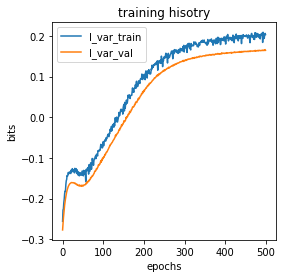

In [43]:
# Show training history
print('On test data:')
# x_test = test_df['x'].values
# y_test = test_df[y_cols].values


I_var_hist = model.history['I_var']
val_I_var_hist = model.history['val_I_var']

fig, ax = plt.subplots(1,1,figsize=[4,4])
ax.plot(I_var_hist, label='I_var_train')
ax.plot(val_I_var_hist, label='I_var_val')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('training hisotry')

fig.savefig('pngs/DiscreteMonotonic_MP/history.png',dpi=200,bbox_inches='tight')

In [20]:
phi = gpmap.x_to_phi(x_test)

In [21]:
theta = np.squeeze(gpmap.weights[1].numpy())
theta_df = pd.DataFrame(theta,columns=model.alphabet)

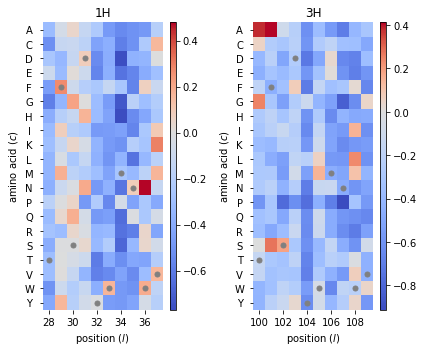

In [31]:
fig, axs = plt.subplots(1,2, figsize=(6,5))

# Draw heatmap
heatmap_ax, cb = mavenn.heatmap(ax=axs[0],
                                values=theta_df.loc[0:9].values,
                                alphabet=model.alphabet,
                                seq=model.x_stats['consensus_seq'],
                                seq_kwargs={'c':'gray', 's':25},
                                cmap='coolwarm',
                                cbar=True,
                                #cmap_size='2%',
                                #cmap_pad=.3,
                                ccenter=0)
# Style heatmap (can be different between two dataset)
heatmap_ax.set_xticks(np.arange(0,10,2))
heatmap_ax.set_xticklabels(np.arange(28,38,2))
heatmap_ax.tick_params(axis='y', which='major', pad=10)
heatmap_ax.set_xlabel('position ($l$)')
heatmap_ax.set_ylabel('amino acid ($c$)')
heatmap_ax.set_title(f'1H')

heatmap_ax, cb = mavenn.heatmap(ax=axs[1],
                                values=theta_df.loc[10:20].values,
                                alphabet=model.alphabet,
                                seq=model.x_stats['consensus_seq'],
                                seq_kwargs={'c':'gray', 's':25},
                                cmap='coolwarm',
                                cbar=True,
                                #cmap_size='2%',
                                #cmap_pad=.3,
                                ccenter=0)
# Style heatmap (can be different between two dataset)
heatmap_ax.set_xticks(np.arange(0,10,2))
heatmap_ax.set_xticklabels(np.arange(100,110,2))
heatmap_ax.tick_params(axis='y', which='major', pad=10)
heatmap_ax.set_xlabel('position ($l$)')
heatmap_ax.set_ylabel('amino acid ($c$)')
heatmap_ax.set_title(f'3H')

fig.tight_layout()
fig.savefig('pngs/DiscreteMonotonic_MP/GP_map.png',dpi=200,bbox_inches='tight')

In [23]:
#np.save('titeseq_gpmap_discrete_agnostic',logo.df.values.ravel())

In [24]:
# sortseq_gpmap = np.load('sortseq_gpmap_discrete_agnostic.npy')
# titeseq_gpmap = -np.load('titeseq_gpmap_discrete_agnostic.npy')

In [25]:
# plt.figure(figsize=(5,5))
# # Compute R^2 between yhat_test and y_test
# Rsq = np.corrcoef(sortseq_gpmap,titeseq_gpmap)[0, 1]**2

# # Style plot
# xlim = [-1.5, 1.5]

# plt.scatter(sortseq_gpmap,titeseq_gpmap,s=4,color='blue',alpha=0.2)
# plt.xlabel('Sortseq G-P map parameters')
# plt.ylabel('Titeseq G-P map parameters')
# plt.title(f'$R^2$={Rsq:.3}');
# plt.plot(xlim, xlim, '--', color='k', label='diagonal')
# plt.xlim(xlim)
# plt.ylim(xlim)
# plt.show()

/var/folders/kx/rdhxdz2129n1dd59rnympr580000gp/T/ipykernel_61915/3256359711.py:46: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cb = plt.colorbar(im)


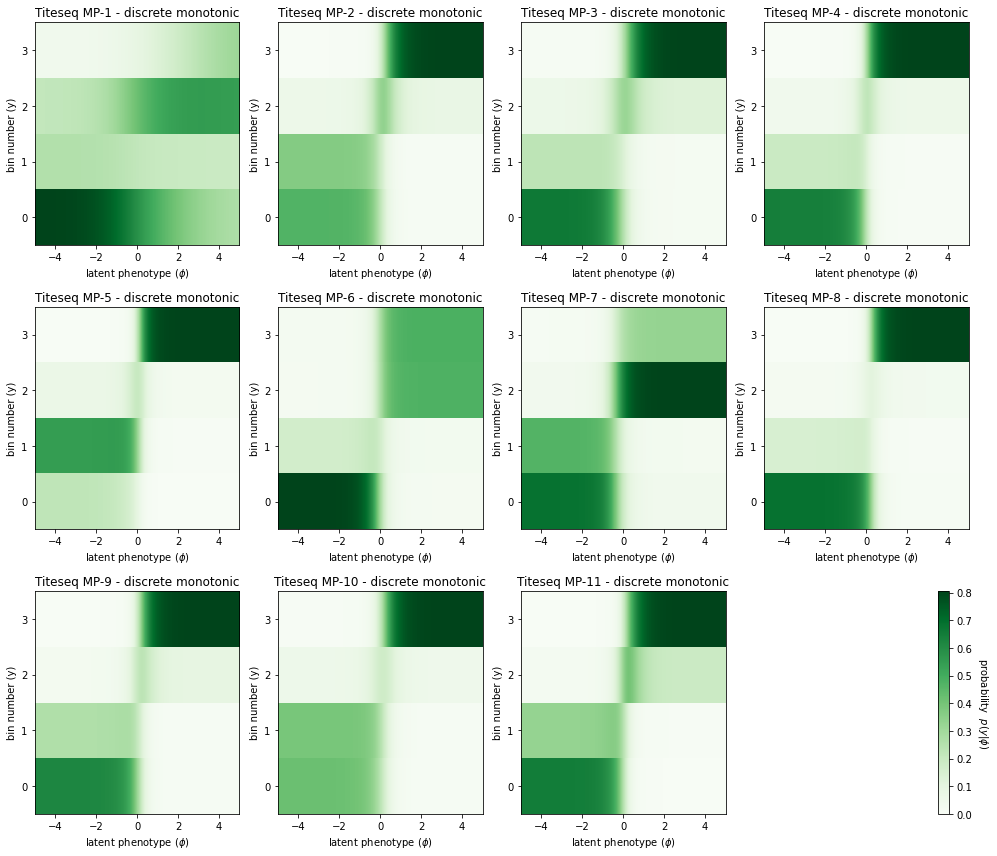

In [44]:
# Create grid in phi space
phi_lim = [-5, 5]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
Y = mp_list[0].Y    # Y = number of bins
y_lim = [-.5, Y-.5]
y_all = range(Y)

# Compute matrix of p(y|phi) values



# Create figure with two panels
fig, axs = plt.subplots(3,4,figsize=[14,12])

mp_counter = 0
for i in range(3):
    for j in range(4):
        

        if mp_counter==11:
            axs[i,j].axis('off')
            break
        measurement_process = mp_list[mp_counter].p_of_y_given_phi(y_all, phi_grid)
        # Right panel: draw measurement process as heatmap
        ax = axs[i,j]

        im = ax.imshow(measurement_process,
                       cmap='Greens',
                       extent=phi_lim+y_lim,
                       vmin=0,
                       origin='lower',
                       interpolation='nearest',
                       aspect="auto")
        ax.set_yticks(y_all)
        ax.set_ylabel('bin number (y)')
        ax.set_xlabel('latent phenotype ($\phi$)')
        ax.set_title(f'Titeseq MP-{mp_counter+1} - discrete monotonic')
        mp_counter+=1
        
#         if mp_counter ==11:
#             cb = plt.colorbar(im,ax=ax)
#             cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")        
        
cb = plt.colorbar(im)
cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")
fig.tight_layout()

fig.savefig('pngs/DiscreteMonotonic_MP/MPs.png',dpi=200,bbox_inches='tight')
